In [1]:
#
# 2017-08-31
#
# XGB - решение - дурняк, но работает
#
#
#

In [2]:
import sys, os, math, datetime
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
def dataClean( df ) :
    def cn (cc) : 
        cc = np.reshape(cc.values,(len(df)))
        return([jj for jj,dd in enumerate(cc.tolist()) if dd ])
    ##df=df.fillna(0.0)
    badly = np.zeros((len(df)),dtype=np.int32)
    ##cols  = df.columns.tolist()
    ##print(cols)
    for ii,nn in enumerate(df.columns.tolist()) :
        
        if (ii==0) and (nn.startswith('Chloro')) : # Chlorophyl
            cc = ((df[[ii]]<0.0) | (df[[ii]]>1.0))
            df.iloc[cn(cc),ii] = 0.0
            #badly[cn(cc)] += 1
        
        if (ii==1) and (nn.startswith('Depth')) : 
            cc = (df[[ii]]> 0.0);      df.iloc[cn(cc),ii] = -df.iloc[cn(cc),ii]
            cc = (df[[ii]]< -10000.0); df.iloc[cn(cc),ii] = -10000.0
            badly[cn(cc)] += 1
        
        if (ii==3) and (nn.startswith('Eastward')) :
            cc = (df[[ii]]< 0.0);      df.iloc[cn(cc),ii] = 0.0
            cc = (df[[ii]]> 5.0);      df.iloc[cn(cc),ii] = 5.0
            badly[cn(cc)] += 1
        
        if (ii==4) and (nn.startswith('Latitude')) :
            cc = (df[[ii]]< -90.0);      df.iloc[cn(cc),ii] = -90.0; badly[cn(cc)] += 1
            cc = (df[[ii]]>  90.0);      df.iloc[cn(cc),ii] =  90.0; badly[cn(cc)] += 1
        
        if (ii==5) and (nn.startswith('Longitude')) :
            cc = (df[[ii]]< -180.0);      df.iloc[cn(cc),ii] = -180.0; badly[cn(cc)] += 1
            cc = (df[[ii]]>  180.0);      df.iloc[cn(cc),ii] =  180.0; badly[cn(cc)] += 1
        
        if (ii==6) and (nn.startswith('Northward')) :
            cc = (df[[ii]]< 0.0);      df.iloc[cn(cc),ii] = 0.0
            cc = (df[[ii]]> 5.0);      df.iloc[cn(cc),ii] = 5.0
            badly[cn(cc)] += 1
        
        if (ii==7) and (nn.startswith('Oceanic')) : 
            cc = (df[[ii]]> 0.0);      df.iloc[cn(cc),ii] = -df.iloc[cn(cc),ii]
            cc = (df[[ii]]< -10000.0); df.iloc[cn(cc),ii] = -10000.0
            badly[cn(cc)] += 1
        
        if (ii==8) and (nn.startswith('SOG')) : 
            cc = (df[[ii]]<  0.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
            cc = (df[[ii]]> 35.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
        
        if (ii==9) and (nn.startswith('Salinity')) : 
            cc = (df[[ii]]<  0.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
            #cc = (df[[ii]]> 35.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
        
        if (ii==10) and (nn.startswith('Sea')) : 
            cc = (df[[ii]]<  0.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
            #cc = (df[[ii]]> 35.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
        
        if (ii==11) and (nn.startswith('Speed')) : 
            cc = (df[[ii]]<  0.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1
            cc = (df[[ii]]> 35.0);      df.iloc[cn(cc),ii] =  0.0; badly[cn(cc)] += 1

        if (ii==11) and (nn.startswith('Thermocline')) : 
            cc = (df[[ii]]<     0.0);      df.iloc[cn(cc),ii] =     0.0; badly[cn(cc)] += 1
            cc = (df[[ii]]>  5000.0);      df.iloc[cn(cc),ii] =  5000.0; badly[cn(cc)] += 1

        if (ii==15) and (nn.startswith('Water')) : 
            cc = (df[[ii]]<  -100.0);      df.iloc[cn(cc),ii] =     0.0; badly[cn(cc)] += 1
            #cc = (df[[ii]]>  5000.0);      df.iloc[cn(cc),ii] =  5000.0; badly[cn(cc)] += 1

    print(cc.sum(),badly.sum())
    return(badly)

In [4]:
# Читаем train список
train_list = pd.read_csv('../Data/training.txt', header=None)
train_list.columns=['trackfile','typing']

In [5]:
train_list.head()

,trackfile,typing
0,100047,trawler
1,100070,longliner
2,100080,seiner
3,100093,other
4,100144,trawler


In [6]:
y_class = train_list['typing'].unique().tolist(); y_class

['trawler', 'longliner', 'seiner', 'other', 'support']

In [7]:
# Читаем test список
test_list = pd.read_csv('../Data/testing.txt', header=None)
test_list.columns=['trackfile']
print 'test length:',len(test_list)
test_list.head()

test length: 1211


,trackfile
0,100015
1,100045
2,100060
3,100112
4,100131


In [1014]:
# Построение массива с данными по списку файлов

def buildX (file_list, nFiles=-1, maxSpeed=35.0, maxSOG=35.0, rWindow=5, hTimeMin=False, hTimeMax=False, fillOK=False) :
    
    
    for ii,ffile in enumerate(file_list) :
        if ii==nFiles : break
        xx = pd.read_csv(os.path.join('../Data/VesselTracks',str(ffile)+'.csv'))
        
        ##print(ii,ffile)
        
        # Small corrections: (latitude&longitude), timing
        
        xx = xx[(xx.Latitude >=-90.0)  & (xx.Latitude <= 90.0)];
        xx = xx[(xx.Longitude>=-180.0) & (xx.Longitude<=180.0)];
        
        xx['Time']  = xx[[1]]
        xx['sTime'] = np.abs(xx.Time.diff(-1)).fillna(0.0)
        xx['hTime'] = xx.sTime/3600.0
        
        if hTimeMin : 
            xx          = xx[xx.hTime>=hTimeMin]
            xx['sTime'] = np.abs(xx.Time.diff(-1)).fillna(0.0)
            xx['hTime'] = xx.sTime/3600.0
            
        havLa       = (0.5*(1.0-np.cos(-xx.Latitude.diff(-1)/180.0*math.pi))).fillna(0.0)
        lLongitude  = xx.Longitude+360.0
        havLo       = (0.5*(1.0-np.cos(-lLongitude.diff(-1)/180.0*math.pi))).fillna(0.0)

        cosLa       = (np.cos(xx.Latitude/180.0*math.pi)).fillna(0.0)

        hav         = (havLa+cosLa*cosLa.shift(-1)*havLo).fillna(0.0)
        dist = (2*6371.0*np.arcsin(np.sqrt(hav))).fillna(0.0)

        xx['Distance'] = dist
        xx['Speed']    = np.round((dist/1.852/xx.hTime).fillna(0.0),2)
        xx.loc[xx.Speed>maxSpeed,'Speed'] = maxSpeed
        
        if hTimeMax : 
            xx.sTime[xx.hTime<=hTimeMax] = 0.0
            xx.hTime[xx.hTime<=hTimeMax] = 0.0
        
        # rolling Speed
        rSOG      = xx.SOG.rolling(window=rWindow, min_periods=1).mean()
        rSOGmd    = xx.SOG.rolling(window=rWindow, min_periods=1).median()
        rSpeed    = xx.Speed.rolling(window=rWindow, min_periods=1).mean()
        rDistance = xx.Distance.rolling(window=rWindow, min_periods=1).mean()
        rTime     = xx.hTime.rolling(window=rWindow, min_periods=1).mean()
        rDTSpeed = (rDistance/rTime/1.852).fillna(0.0)
        
        xx['rSpeed'] = np.round(np.clip(rSpeed,0.0,maxSpeed),2)
        xx['rSOG']   = np.round(np.clip(rSOG,0.0,maxSpeed),2)
        xx['rSOGmd'] = np.round(np.clip(rSOGmd,0.0,maxSpeed),2)
        xx['rDTSpeed'] = np.round(np.clip(rDTSpeed,0.0,maxSpeed),2)
        
        xx.loc[xx.SOG>maxSOG,'SOG'] = xx.loc[xx.SOG>maxSOG,'rSOG']
        xx.loc[xx.SOG<0.0,'SOG']    = xx.loc[xx.SOG<0.0,'rSOG']

        if fillOK : xx = xx.fillna(fillOK)

        if (ii==0) : resAll = xx.copy()
        else       : resAll = resAll.append(xx.copy())

    ##print(trainAll.shape)
    return (resAll)

def buildY (file_list, y_classes) :
    
    trainIndex=file_list.copy()
    trainIndex['y'] = np.array(map(y_classes.index,trainIndex.typing.tolist()))
    return(trainIndex)

In [544]:
print datetime.datetime.now()
trainAll_ = buildX(train_list['trackfile'].values.tolist(), nFiles=12) #, hTimeMin=5.0/3600);
temp      = '\tLatitudes: between {} and {} \n\tLongitudes: between {} and {} \n\tFiles={} Shapes={}'
print(temp.format(trainAll_.Latitude.min(), trainAll_.Latitude.max(), trainAll_.Longitude.min(), 
                  trainAll_.Longitude.max(), len(trainAll_.TrackNumber.unique()),  trainAll_.shape))
print datetime.datetime.now()
##len(trainAll_.TrackNumber.unique()),trainAll_.TrackNumber.unique(),trainAll_.tail()

2017-09-04 01:39:50.834822
	Latitudes: between -67.458415 and 56.720937 
	Longitudes: between -179.67688 and 179.980242 
	Files=12 Shapes=(68343, 19)
2017-09-04 01:39:51.104943


In [545]:
trainAll_.describe()

,TrackNumber,Time(seconds),Latitude,Longitude,SOG,oceanic depth,Chlorophyll Concentration,Salinity,Water Surface Elevation,Sea Temperature,Thermocline Depth,Eastward Water Velocity,Northward Water Velocity,Time,sTime,hTime,Distance,Speed,rSpeed
count,68343.000000,6.834300e+04,68343.000000,68343.000000,68343.000000,68343.000000,68343.000000,68343.000000,68343.000000,68343.000000,68343.000000,68343.000000,68343.000000,6.834300e+04,6.834300e+04,68343.000000,68343.000000,68343.000000,68343.000000
mean,100177.603003,3.823745e+06,39.738107,-19.413192,1.510658,-208.938823,-44208.527856,30.038326,-5.191575,4.830204,169.833471,-4.268868,-4.348623,3.823745e+06,1.355213e+03,0.376448,3.105737,2.578414,7.250289
std,79.937088,2.384120e+06,20.018974,79.004114,382.551771,421.545481,49663.762562,662.754271,662.521443,662.693920,667.332902,662.526826,662.526270,2.384120e+06,1.697947e+04,4.716520,133.617179,4.445773,11.243540
min,100047.000000,0.000000e+00,-67.458415,-179.676880,-99999.000000,-1532.000000,-99999.000000,-99999.000000,-99999.000000,-99999.000000,-99999.000000,-99999.000000,-99999.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,100093.000000,1.544225e+06,37.388433,-9.366658,0.000000,-76.000000,-99999.000000,34.000000,-1.760000,-0.800000,136.100000,-0.060000,-0.100000,1.544225e+06,6.100000e+01,0.016944,0.001481,0.010000,0.020000
50%,100144.000000,4.021559e+06,51.415543,8.310493,0.100000,-5.000000,0.145500,34.200000,-1.370000,1.400000,169.000000,0.150000,0.050000,4.021559e+06,4.050000e+02,0.112500,0.004308,0.050000,0.670000
75%,100277.000000,5.945117e+06,53.993879,8.709229,3.600000,0.000000,0.683000,34.700000,-0.010000,14.400000,173.800000,0.310000,0.150000,5.945117e+06,9.300000e+02,0.258333,0.360720,3.200000,9.910000
max,100287.000000,7.948470e+06,56.720937,179.980242,16.800000,132.000000,3.902200,35.800000,0.770000,31.300000,1109.600000,1.160000,1.040000,7.948470e+06,2.163149e+06,600.874722,12436.947142,35.000000,35.000000


In [1015]:
print datetime.datetime.now()
trainAll_ = buildX(train_list['trackfile'].values.tolist(), hTimeMin=2.0/(60.0*60.0));
temp      = '\tLatitudes: between {} and {} \n\tLongitudes: between {} and {} \n\tFiles={} Shapes={}'
print(temp.format(trainAll_.Latitude.min(), trainAll_.Latitude.max(), trainAll_.Longitude.min(), 
                  trainAll_.Longitude.max(), len(trainAll_.TrackNumber.unique()),  trainAll_.shape))
trainAll  = trainAll_
trainAll.to_csv('../Data/trainingAllNew.csv',index=False)
del trainAll_
print datetime.datetime.now()

2017-09-05 02:25:47.457848
	Latitudes: between -89.798397 and 89.64788 
	Longitudes: between -179.999883 and 179.999953 
	Files=1209 Shapes=(7338688, 23)
2017-09-05 02:37:20.750929


In [1016]:
len(train_list['trackfile'].values.tolist())

1209

In [1017]:
trainAll = pd.read_csv('../Data/trainingAllNew.csv')

In [1018]:
#trainWeights = dataClean(trainAll)

In [1019]:
!ls -la ../Data
trainAll.shape

total 4057872
drwxrwxrwx 1 boba boba       4096 сен  4 03:08 .
drwxrwxrwx 1 boba boba       4096 сен  1 16:12 ..
-rwxrwxrwx 1 boba boba  973453918 сен  2 02:54 testingAll.csv
-rwxrwxrwx 1 boba boba  850738365 сен  4 03:08 testingAllNew.csv
-rwxrwxrwx 1 boba boba       8477 авг 25 23:42 testing.txt
-rwxrwxrwx 1 boba boba 1195264916 сен  2 01:53 trainingAll.csv
-rwxrwxrwx 1 boba boba 1135229204 сен  5 02:37 trainingAllNew.csv
-rwxrwxrwx 1 boba boba      18151 авг 25 23:40 training.txt
drwxrwxrwx 1 boba boba     528384 авг 26 00:37 VesselTracks


(7338688, 23)

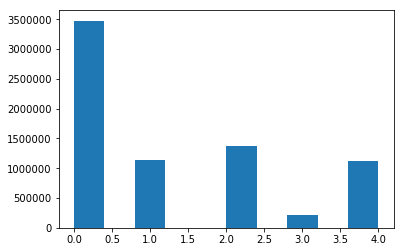

,TrackNumber,Chlorophyll Concentration,Distance,Eastward Water Velocity,Latitude,Longitude,Northward Water Velocity,Oceanic Depth,SOG,Salinity,...,Time(seconds),Water Surface Elevation,hTime,oceanic depth,rDTSpeed,rSOG,rSOGmd,rSpeed,sTime,y
0,100047,0.3105,3.186329,0.06,41.101078,1.235355,0.01,NaN,7.4,34.3,...,0,-0.22,0.258611,-4.0,6.65,7.40,7.40,6.65,931.0,0
1,100047,0.3043,5.981159,0.06,41.074507,1.221120,0.02,NaN,5.1,34.3,...,931,-0.22,0.358333,-11.0,8.02,6.25,6.25,7.83,1290.0,0
2,100047,0.3059,8.779740,0.06,41.043652,1.279553,0.04,NaN,10.2,34.3,...,2221,-0.23,0.458889,-16.0,9.01,7.57,7.40,8.66,1652.0,0
3,100047,0.3674,0.000095,0.08,40.998603,1.365502,0.07,NaN,10.5,34.3,...,3873,-0.24,0.001111,-46.0,9.00,8.30,8.80,6.51,4.0,0
4,100047,0.3674,7.221329,0.08,40.998602,1.365502,0.07,NaN,10.5,34.3,...,3877,-0.24,0.393056,-46.0,9.24,8.74,10.20,7.19,1415.0,0


In [1020]:
trainIndex = buildY(train_list,y_class)
train      = trainAll.set_index('TrackNumber')
train['y'] = trainIndex.set_index('trackfile').y
train      = train.reset_index()
plt.hist(train.y); plt.show(); plt.close()
train.head()

In [1021]:
hTimeMin = 3.0/3600.0
hTimeMax = 48.0

OKtrain = ((train.hTime<=hTimeMax) & (train.hTime>hTimeMin))
NOtrain = np.logical_not(OKtrain)

In [1022]:
import xgboost as xgb

In [1023]:
train_x = train.drop(['y','TrackNumber','Time','Time(seconds)'],axis=1)  #[:1000000]
train_y = train.y.values  #[:1000000]

mtrain = xgb.DMatrix(train_x,label=train_y)

In [1024]:
# Добавляем веса, чтобы не удалять записи из массива
if 0 :
    temp = (0.0+train_x.shape[1]-1.5*trainWeights)/train_x.shape[1]
    mtrain.set_weight(temp)
    trainWeights.min(), trainWeights.max()
    plt.hist(temp,bins=50); plt.show()
    temp.min(),temp.max(), train_x.shape, trainWeights.min(), trainWeights.max()

In [1025]:
train_y.shape, train_x.shape, train_x.columns.tolist(), train_y.max()

((7338688,),
 (7338688, 20),
 ['Chlorophyll Concentration',
  'Distance',
  'Eastward Water Velocity',
  'Latitude',
  'Longitude',
  'Northward Water Velocity',
  'Oceanic Depth',
  'SOG',
  'Salinity',
  'Sea Temperature',
  'Speed',
  'Thermocline Depth',
  'Water Surface Elevation',
  'hTime',
  'oceanic depth',
  'rDTSpeed',
  'rSOG',
  'rSOGmd',
  'rSpeed',
  'sTime'],
 4)

In [1026]:
##import sklearn as sk
##from sklearn.model_selection import cross_val_score

In [1027]:
##cross_val_score(estimator=xgb.XGBClassifier(), X=train_x, y=train_y, cv=5, scoring='accuracy')

In [1028]:
parms = {'reg':'logistic'}
parms = {'multi':'softmax','num_class':5,'metrics':'mlogloss'}
#parms = {'num_class':5,'metrics':'mlogloss'}
parms['objective'] = 'multi:softprob'
parms['eval_metric'] = ['merror','mlogloss']
parms['silent'] = 0

evallist  = [(mtrain,'train')]
##parms = {'reg':'logistic'}
##parms = {'reg':'linear','metrics':'auc'}

##hhcv  = xgb.cv(parms,mtrain,num_boost_round=400,nfold=5,early_stopping_rounds=4,verbose_eval=True,metrics=['merror','mlogloss'])
#hist = xgb.train(parms,mtrain,num_boost_round=30,early_stopping_rounds=5)

In [706]:
hhcv

,test-merror-mean,test-merror-std,test-mlogloss-mean,test-mlogloss-std,train-merror-mean,train-merror-std,train-mlogloss-mean,train-mlogloss-std
0,0.185543,0.001631,1.184000,0.000665,0.185468,0.001425,1.183974,0.000566
1,0.177706,0.000731,0.964420,0.000939,0.177727,0.000833,0.964356,0.000816
2,0.169069,0.001076,0.821264,0.001090,0.168964,0.000995,0.821160,0.000828
3,0.163024,0.000766,0.719096,0.000832,0.162966,0.000857,0.718979,0.000584
4,0.158126,0.001351,0.641246,0.000798,0.158054,0.001411,0.641076,0.000605
5,0.153794,0.001738,0.582834,0.000868,0.153730,0.001778,0.582647,0.001081
6,0.150526,0.002095,0.537238,0.000714,0.150471,0.002122,0.537051,0.000732
7,0.146832,0.000914,0.501902,0.001138,0.146795,0.001026,0.501682,0.000916
8,0.143973,0.001246,0.474114,0.001246,0.143944,0.001252,0.473868,0.000946
9,0.140727,0.002129,0.450779,0.001568,0.140716,0.002052,0.450528,0.001353


In [1030]:
#xgbmodel = xgb.train(parms,mtrain,num_boost_round=1) # empty nodel

In [1077]:
print datetime.datetime.now()
xgbmodel = xgb.train(parms,mtrain,num_boost_round=200, evals=evallist, xgb_model=xgbmodel) # = 400
print datetime.datetime.now()

2017-09-05 04:03:30.805064
[0]	train-merror:0.034114	train-mlogloss:0.10677
[1]	train-merror:0.033968	train-mlogloss:0.106368
[2]	train-merror:0.033835	train-mlogloss:0.105967
[3]	train-merror:0.033701	train-mlogloss:0.10565
[4]	train-merror:0.033583	train-mlogloss:0.105348
[5]	train-merror:0.033446	train-mlogloss:0.104927
[6]	train-merror:0.033306	train-mlogloss:0.10456
[7]	train-merror:0.03314	train-mlogloss:0.104124
[8]	train-merror:0.033018	train-mlogloss:0.103752
[9]	train-merror:0.03284	train-mlogloss:0.103359
[10]	train-merror:0.032705	train-mlogloss:0.10301
[11]	train-merror:0.03257	train-mlogloss:0.10264
[12]	train-merror:0.032481	train-mlogloss:0.102419
[13]	train-merror:0.032361	train-mlogloss:0.101957
[14]	train-merror:0.032201	train-mlogloss:0.10164
[15]	train-merror:0.032056	train-mlogloss:0.101304
[16]	train-merror:0.03189	train-mlogloss:0.100881
[17]	train-merror:0.03178	train-mlogloss:0.100532
[18]	train-merror:0.031679	train-mlogloss:0.100221
[19]	train-merror:0.03147

In [1101]:
#xgbmodel.load_model('../Work/xgbModel.bst')
##xgbmodel.load_model('../Work/xgbModelClean.bst')
##xgbmodel.save_model('../Work/xgbModelCleanSoftProb.bst')
##xgbmodel.save_model('../Work/xgbModel-NotClean-SoftProb-200.bst')
#xgbmodel.save_model('../Work/xgbModel-NotClean-SoftProb-400.bst')
#xgbmodel = xgb.Booster()
#xgbmodel.load_model('../Work/xgbModel-NotClean-SoftProb-400.bst')
xgbmodel.save_model('../Work/xgbModel-NotClean-SoftProb-New2-400.bst')
#xgbmodel.load_model('../Work/xgbModel-NotClean-SoftProb-New2-200.bst')


In [1078]:
pred_y = xgbmodel.predict(mtrain); ##pred_y[-20:],pred_y.max()

In [1079]:
pred_y.shape, pred_y.max() #pred_y[:4]

((7338688, 5), 1.0)

In [1080]:
pred_y_softmax=pred_y.argmax(axis=1); pred_y_softmax.shape

(7338688,)

In [1081]:
((pred_y_softmax==train_y).sum()/float(len(pred_y)))

0.98157804228766776

In [1082]:
df_diff = pd.DataFrame(train.TrackNumber,columns=['TrackNumber'])
df_diff['true_y'] = np.array(train_y,dtype=np.uint8)
df_diff['pred_y'] = np.array(pred_y_softmax, dtype=np.uint8)

df_diff['OK']    = df_diff.true_y==df_diff.pred_y

#print(df_diff.head())

len(df_diff)-df_diff.OK.sum()
aa = df_diff.groupby(['TrackNumber','OK']).size().reset_index(); aa.columns=['TrackNumber','OK','ccount']; aa.head()
bb = pd.DataFrame(train.TrackNumber.unique(),columns=['TrackNumber'])
bb['xx'] = 1.0; bb=bb.set_index(['TrackNumber'])
cc = aa[['TrackNumber','ccount']][aa.OK==True];  cc.head(); cc = cc.set_index(['TrackNumber']); bb['Yes']=cc
cc = aa[['TrackNumber','ccount']][aa.OK==False]; cc.head(); cc = cc.set_index('TrackNumber'); bb['No'] =cc
bb=bb.reset_index().drop('xx',axis=1).fillna(0)
print(bb.head())
float(len(bb[bb.No>bb.Yes]))/len(bb)*100.0

   TrackNumber      Yes    No
0       100047    650.0   0.0
1       100070    343.0  53.0
2       100080   9756.0   6.0
3       100093   5463.0  40.0
4       100144  15427.0   0.0


0.6617038875103392

In [1083]:
#trainAll.describe()

In [1084]:
#testAll.describe()

In [1085]:
fimp  = xgbmodel.get_fscore();
ffimp = [[k,fimp[k]] for k in fimp.keys()]; 
ffimp.sort(key=lambda x: x[1],reverse=True)
tempsum = 0
for temp in ffimp : tempsum+=temp[1];
##print(tempsum)
for ii,temp in enumerate(ffimp) : 
    ffimp[ii][1] = float(ffimp[ii][1])/tempsum*100.0;
ffimp

[['Longitude', 13.118131868131869],
 ['Latitude', 11.774064543051885],
 ['Oceanic Depth', 10.848170816525247],
 ['Eastward Water Velocity', 6.698602030880512],
 ['Water Surface Elevation', 6.369105577966337],
 ['Sea Temperature', 6.135241340937544],
 ['Northward Water Velocity', 5.932674920016693],
 ['Chlorophyll Concentration', 5.798789817777159],
 ['Thermocline Depth', 5.6353456669912365],
 ['Salinity', 4.784218945611351],
 ['rSOGmd', 4.249547920433996],
 ['rDTSpeed', 3.6035957713172904],
 ['rSOG', 3.3601683126999586],
 ['SOG', 2.642926693559605],
 ['rSpeed', 2.2091041869522883],
 ['oceanic depth', 1.895256642092085],
 ['hTime', 1.8535262206148282],
 ['Distance', 1.6474822645708722],
 ['Speed', 1.4440464598692446]]

In [1086]:
y_class, trainIndex[trainIndex.trackfile==100093].typing

(['trawler', 'longliner', 'seiner', 'other', 'support'], 3    other
 Name: typing, dtype: object)

In [1087]:
hTimeMin = 10.0/3600.0
hTimeMax = 48.0

OKtrain = ((train.hTime<=hTimeMax) & (train.hTime>hTimeMin))
NOtrain = np.logical_not(OKtrain)

In [1088]:
if 0 :
    train_o          = train.copy()
    pred_y_o         = pred_y.copy()
    pred_y_softmax_o = pred_y_softmax.copy()
if 0 :
    train            = train_o.copy()
    pred_y           = pred_y_o.copy()
    pred_y_softmax   = pred_y_softmax_o.copy()
len(train), len(pred_y), len(pred_y_softmax), train.shape

(7338688, 7338688, 7338688, (7338688, 24))

In [1089]:
if 0 :
    train          = train[OKtrain]
    pred_y         = pred_y[OKtrain]
    pred_y_softmax = pred_y_softmax[OKtrain]

In [1090]:
len(train), len(pred_y), len(pred_y_softmax)

(7338688, 7338688, 7338688)

    TrackNumber  pred_y        pr
0        100047       0  1.000000
1        100070       1  0.866162
2        100070       2  0.133838
3        100080       2  0.999385
4        100080       4  0.000615
5        100093       0  0.007269
6        100093       3  0.992731
7        100144       0  1.000000
8        100161       1  1.000000
9        100175       0  0.998866
10       100175       1  0.001134
11       100204       0  0.958957
12       100204       1  0.028645
13       100204       2  0.011971
14       100204       3  0.000428
15       100216       3  1.000000
16       100262       0  1.000000
17       100277       1  0.000481
18       100277       2  0.999519
19       100287       0  0.999929


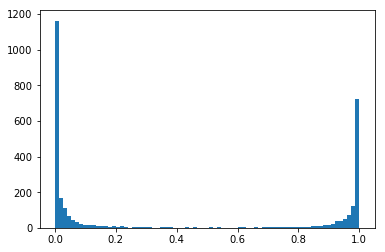

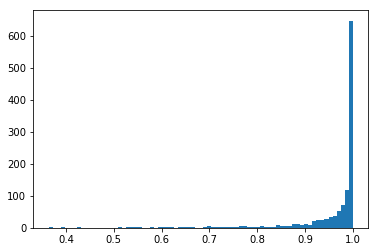

12

In [1091]:
ppred = pd.DataFrame()
ppred['TrackNumber'] = train.TrackNumber
ppred['pred_y']      = pred_y_softmax
ppred['true_y']      = train.y

g0pred = ppred.groupby(['TrackNumber','pred_y']).size()
g1pred = ppred.groupby(ppred.TrackNumber).size(); #print(len(g1pred),g1pred.head())
temp   = np.round(g0pred/g1pred,6)
g0pred = g0pred.reset_index()
g0pred.columns = ['TrackNumber','pred_y','pr']
g0pred['pr'] = temp.values
'''
g0pred = g0pred.set_index(['TrackNumber','pred_y']).unstack(level=-1).fillna(0.0); 
g0pred.columns=[0,1,2,3,4]
print(g0pred.head(20)) #,g0pred.columns)
if 1 :
    for nn in g0pred.columns : g0pred[nn][g0pred[nn]<=0.05] = 0.0;
    temp     = g0pred.sum(axis=1); temp.shape #, g100pred.shape; g100pred,temp.head()
    for nn in g0pred.columns : g0pred[nn] = np.round(g0pred[nn]/temp,6);

temp = g0pred.stack().fillna(0.0)
temp = temp[temp>0.0]
g0pred = temp.reset_index()
g0pred.columns = ['TrackNumber','pred_y','pr']
'''
print(g0pred.head(20))

g2pred = g0pred.reset_index()
g2pred = g2pred.pr.groupby(g2pred.TrackNumber).max()
plt.hist(g0pred.pr,bins=75); plt.show()
plt.hist(g2pred,bins=75); plt.show()
#g0pred
g2pred.head()
len(g2pred[g2pred<0.60])

In [1092]:
#Построение train-решения через probs без времени, только частотность

g100     = pd.DataFrame(pred_y); g100.head(), g100.columns
g100pred = g100.groupby(ppred.TrackNumber).sum(); g100pred.head()
temp     = g100pred.sum(axis=1); temp.shape #, g100pred.shape; g100pred,temp.head()
for nn in g100pred.columns : g100pred[nn] = np.round(g100pred[nn]/temp,6); 
g100pred.head()
if 1 :
    for nn in g100pred.columns : g100pred[nn][g100pred[nn]<=0.05] = 0.0;
    temp     = g100pred.sum(axis=1); temp.shape #, g100pred.shape; g100pred,temp.head()
    for nn in g100pred.columns : g100pred[nn] = np.round(g100pred[nn]/temp,6);

temp = g100pred.stack()
temp = temp[temp>0.0]
g100pred = pd.DataFrame(temp.reset_index());
g100pred.columns=['TrackNumber','pred_y','pr']
del temp
g100pred.head(30), g100pred.pred_y.dtype

(    TrackNumber  pred_y        pr
 0        100047       0  1.000000
 1        100070       1  0.743494
 2        100070       2  0.256506
 3        100080       2  1.000000
 4        100093       3  1.000000
 5        100144       0  1.000000
 6        100161       1  1.000000
 7        100175       0  1.000000
 8        100204       0  0.932952
 9        100204       1  0.067048
 10       100216       3  1.000000
 11       100262       0  1.000000
 12       100277       2  1.000000
 13       100287       0  1.000000
 14       100305       0  1.000000
 15       100321       0  1.000000
 16       100362       1  0.583712
 17       100362       2  0.416288
 18       100370       0  1.000000
 19       100380       2  1.000000
 20       100383       0  0.053848
 21       100383       1  0.051864
 22       100383       2  0.894288
 23       100403       0  1.000000
 24       100448       2  0.057984
 25       100448       4  0.942016
 26       100453       1  1.000000
 27       100457    

In [1093]:
g110     = pd.DataFrame(pred_y) # в работе время 
for nn in g110.columns : g110[nn] = np.round(g110[nn]*0.5*(train.sTime+train.sTime.shift().fillna(0.0)),6);
    
g110pred = g110.groupby(ppred.TrackNumber).sum(); g110pred.head()
temp     = g110pred.sum(axis=1); temp.shape #, g110pred.shape; g110pred,temp.head()
for nn in g110pred.columns : g110pred[nn] = np.round(g110pred[nn]/temp,6);
if 1 :
    for nn in g110pred.columns : g110pred[nn][g110pred[nn]<=0.05] = 0.0;
    temp     = g110pred.sum(axis=1); temp.shape #, g110pred.shape; g110pred,temp.head()
    for nn in g110pred.columns : g110pred[nn] = np.round(g110pred[nn]/temp,6);

g110pred.head(15)

temp = g110pred.stack()
temp = temp[temp>0.0]
g110pred = pd.DataFrame(temp.reset_index());
g110pred.columns=['TrackNumber','pred_y','pr']
del temp
g110pred.head(20), g110pred.pred_y.dtype, g110pred.pr.max()

(    TrackNumber  pred_y        pr
 0        100047       0  1.000000
 1        100070       1  0.744725
 2        100070       2  0.255275
 3        100080       2  1.000000
 4        100093       0  0.129944
 5        100093       3  0.870056
 6        100144       0  1.000000
 7        100161       1  1.000000
 8        100175       0  1.000000
 9        100204       0  0.870665
 10       100204       1  0.129335
 11       100216       3  1.000000
 12       100262       0  1.000000
 13       100277       2  1.000000
 14       100287       0  1.000000
 15       100305       0  1.000000
 16       100321       0  0.829412
 17       100321       1  0.067895
 18       100321       3  0.102693
 19       100362       1  0.798351, dtype('int64'), 1.0)

In [1094]:
ggtrain = pd.DataFrame(train[['TrackNumber','y']].groupby(['TrackNumber','y']).size().reset_index()); ggtrain.head()
ggtrain.columns   = ['TrackNumber','pred_y','size']
ggtrain['true_y'] = 1.0
ggtrain.head()

,TrackNumber,pred_y,size,true_y
0,100047,0,650,1.0
1,100070,1,396,1.0
2,100080,2,9762,1.0
3,100093,3,5503,1.0
4,100144,0,15427,1.0


In [1095]:
#ggtrain  = ggtrain.reset_index()
#g100pred = g100pred.reset_index()
#gg.reset_index()

In [1096]:
#ggtrain  = ggtrain.set_index(['TrackNumber','pred_y'])
#g100pred = g100pred.set_index(['TrackNumber','pred_y']) 
gg = pd.merge(g0pred.reset_index(),ggtrain,how='outer',suffixes=('_x','_y'),on=('TrackNumber','pred_y'))
gg = gg.drop('size',axis=1).fillna(0.0)
print(gg.tail(15))
ggBad = gg[(gg.pr!=gg.true_y) & (gg.pr<0.50) & (gg.true_y>0.50)]['TrackNumber'].unique(); ggBad
##gg.set_index('TrackNumber')
ggBadTracks = gg.set_index('TrackNumber').loc[ggBad.tolist(),:].reset_index().TrackNumber.unique()
print len(ggBadTracks), ggBadTracks.tolist()
##gg.reset_index()
#ggtrain.pred_y.dtype
#g100pred.pred_y.dtype

       index  TrackNumber  pred_y        pr  true_y
2935  2935.0       132557       4  0.981936     1.0
2936  2936.0       132588       0  0.970225     1.0
2937  2937.0       132588       1  0.029775     0.0
2938  2938.0       132642       0  0.000175     0.0
2939  2939.0       132642       1  0.000175     0.0
2940  2940.0       132642       2  0.007004     0.0
2941  2941.0       132642       4  0.992646     1.0
2942  2942.0       132644       1  0.001922     0.0
2943  2943.0       132644       2  0.989908     1.0
2944  2944.0       132644       4  0.008170     0.0
2945  2945.0       132653       0  0.998363     1.0
2946  2946.0       132653       2  0.001637     0.0
2947  2947.0       132759       2  0.989957     1.0
2948  2948.0       132759       4  0.010043     0.0
2949     0.0       124127       0  0.000000     1.0
8 [112859, 113817, 122298, 122635, 123632, 126567, 127152, 124127]


In [1097]:
gg.head()
gg.set_index('TrackNumber').loc[124127,:]
#ggBad.tolist()
train[train.TrackNumber==124127].iloc[:,:] #range(7)+[9,10,11,12,13,14,16,17,18,19,20]]
#train[train.TrackNumber==131933].iloc[:,range(4)+[5,8,9,11,12,13,14,16,17,18,19,20]]

,TrackNumber,Chlorophyll Concentration,Distance,Eastward Water Velocity,Latitude,Longitude,Northward Water Velocity,Oceanic Depth,SOG,Salinity,...,Time(seconds),Water Surface Elevation,hTime,oceanic depth,rDTSpeed,rSOG,rSOGmd,rSpeed,sTime,y
5377278,124127,-99999.0,0.002271,0.09,43.658698,-7.352898,0.33,-6.0,0.0,34.4,...,0,-0.31,0.251111,NaN,0.00,0.0,0.0,0.00,904.0,0
5377279,124127,-99999.0,0.003463,0.09,43.658692,-7.352925,0.33,-6.0,0.0,34.4,...,904,-0.31,0.280278,NaN,0.01,0.0,0.0,0.00,1009.0,0
5377280,124127,-99999.0,0.279200,0.09,43.658672,-7.352958,0.33,-6.0,0.0,34.4,...,1913,-0.31,582.999722,NaN,0.00,0.0,0.0,0.00,2098799.0,0
5377281,124127,-99999.0,0.004969,0.30,43.657407,-7.349960,-0.06,-6.0,0.0,34.3,...,2100712,-0.23,0.263333,NaN,0.00,0.0,0.0,0.00,948.0,0
5377282,124127,-99999.0,0.005168,0.30,43.657378,-7.350007,-0.06,-6.0,0.0,34.3,...,2101660,-0.23,0.261389,NaN,0.00,0.0,0.0,0.01,941.0,0
5377283,124127,-99999.0,0.005193,0.30,43.657382,-7.349943,-0.06,-6.0,0.0,34.3,...,2102601,-0.23,0.263889,NaN,0.00,0.0,0.0,0.01,950.0,0
5377284,124127,-99999.0,0.002563,0.30,43.657395,-7.350005,-0.06,-6.0,0.0,34.3,...,2103551,-0.23,0.261389,NaN,0.00,0.0,0.0,0.01,941.0,0
5377285,124127,-99999.0,0.000000,0.30,43.657418,-7.350007,-0.06,-6.0,0.0,34.3,...,2104492,-0.23,0.000000,NaN,0.01,0.0,0.0,0.01,0.0,0


In [1098]:
tr000 = g0pred.copy()
tr100 = g100pred.copy()
tr110 = g110pred.copy()

In [1057]:
# Готовим решение по test

In [1058]:
print datetime.datetime.now()
testAll_ = buildX(test_list['trackfile'].values.tolist(), hTimeMin=2.0/(60.0*60.0));
temp      = '\tLatitudes: between {} and {} \n\tLongitudes: between {} and {} \n\tFiles={} Shapes={}'
print(temp.format(testAll_.Latitude.min(), testAll_.Latitude.max(), testAll_.Longitude.min(), 
                  testAll_.Longitude.max(), len(testAll_.TrackNumber.unique()),  testAll_.shape))
testAll  = testAll_
testAll.to_csv('../Data/testingAllNew.csv',index=False)
del testAll_
print datetime.datetime.now()

2017-09-05 03:22:55.201483


/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


	Latitudes: between -89.829942 and 89.098423 
	Longitudes: between -179.999995 and 179.99999 
	Files=1211 Shapes=(6059553, 23)
2017-09-05 03:33:01.088694


In [1060]:
#testAll.to_csv('../Data/testingAll.csv',index=False)

In [1061]:
testAll = pd.read_csv('../Data/testingAllNew.csv')

In [1062]:
#testWeights = dataClean(testAll)

In [1102]:
!ls -la ../Result
!ls -la ../Data
!ls -la ../Work
testAll.shape

total 193
drwxrwxrwx 1 boba boba   4096 сен  5 03:52 .
drwxrwxrwx 1 boba boba   4096 сен  1 16:12 ..
drwxrwxrwx 1 boba boba      0 сен  5 03:52 Best
-rwxrwxrwx 1 boba boba 185605 сен  5 03:52 bobaFish-917339.csv
-rwxrwxrwx 1 boba boba    413 сен  1 16:53 FishingForFishermen2.java
drwxrwxrwx 1 boba boba      0 сен  1 16:36 .ipynb_checkpoints
total 4138320
drwxrwxrwx 1 boba boba       4096 сен  4 03:08 .
drwxrwxrwx 1 boba boba       4096 сен  1 16:12 ..
-rwxrwxrwx 1 boba boba  973453918 сен  2 02:54 testingAll.csv
-rwxrwxrwx 1 boba boba  933116782 сен  5 03:33 testingAllNew.csv
-rwxrwxrwx 1 boba boba       8477 авг 25 23:42 testing.txt
-rwxrwxrwx 1 boba boba 1195264916 сен  2 01:53 trainingAll.csv
-rwxrwxrwx 1 boba boba 1135229204 сен  5 02:37 trainingAllNew.csv
-rwxrwxrwx 1 boba boba      18151 авг 25 23:40 training.txt
drwxrwxrwx 1 boba boba     528384 авг 26 00:37 VesselTracks
total 82188
drwxrwxrwx 1 boba boba     4096 сен  5 12:29 .
drwxrwxrwx 1 boba boba     4096 сен  1 16:12 ..
dr

(6059553, 23)

In [1103]:
test_x = testAll.drop(['TrackNumber','Time','Time(seconds)'],axis=1)  #[:1000000]
mtest  = xgb.DMatrix(test_x)
test_x.shape

(6059553, 20)

In [1104]:
test_y = xgbmodel.predict(mtest); ##pred_y[-20:],pred_y.max()

In [1105]:
test_y_softmax = test_y.argmax(axis=1); test_y_softmax.shape

(6059553,)

In [1106]:
test = testAll

In [1107]:
if 0 :
    test_o           = test.copy()
    test_y_o         = test_y.copy()
    test_y_softmax_o = test_y_softmax.copy()
if 0 :
    test             = test_o.copy()
    test_y           = test_y_o.copy()
    test_y_softmax   = test_y_softmax_o.copy()
len(test), len(test_y), len(test_y_softmax)

(6059553, 6059553, 6059553)

In [1108]:
if 0 :
    test           = test[OKtest]
    test_y         = test_y[OKtest]
    test_y_softmax = test_y_softmax[OKtest]
len(test), len(test_y), len(test_y_softmax)

(6059553, 6059553, 6059553)

('Common result \n',     TrackNumber  pred_y      pr
0        100015       0  0.0341
1        100015       1  0.8573
2        100015       2  0.1061
3        100015       3  0.0025
4        100045       0  1.0000
5        100060       0  0.0467
6        100060       1  0.8417
7        100060       2  0.1117
8        100112       0  1.0000
9        100131       0  0.9566
10       100131       1  0.0024
11       100131       3  0.0410
12       100150       1  0.9464
13       100150       2  0.0530
14       100150       4  0.0006
15       100151       0  0.0756
16       100151       1  0.0039
17       100151       2  0.0452
18       100151       4  0.8752
19       100215       0  0.4118
20       100215       1  0.3529
21       100215       2  0.2353
22       100221       0  1.0000
23       100227       0  0.9994
24       100227       1  0.0003)


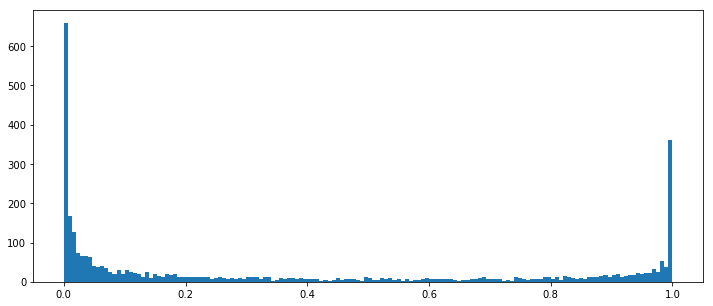

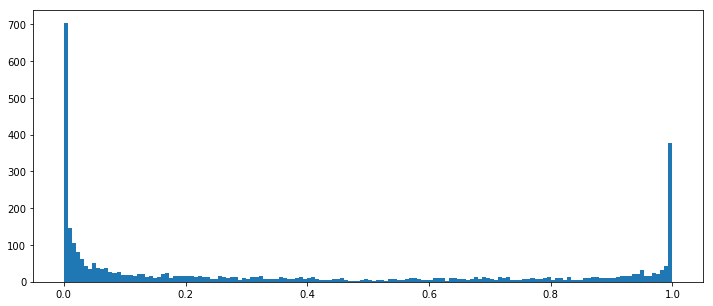

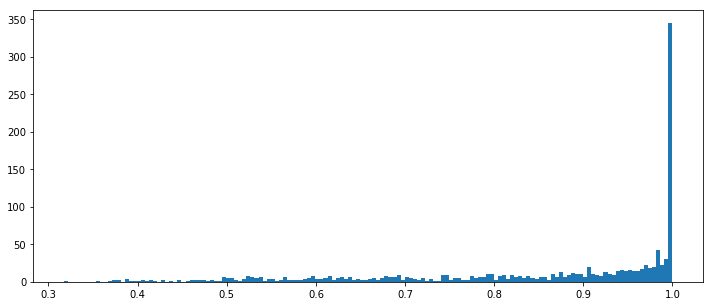

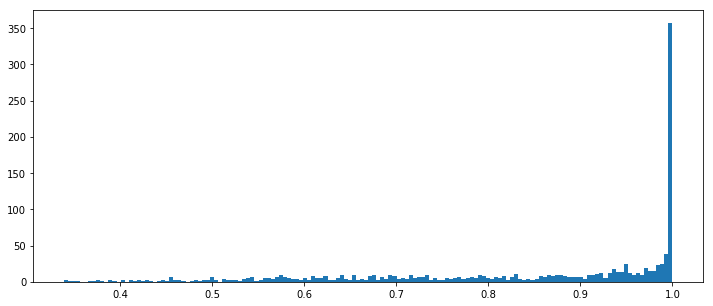

144 0.0 1.0 0.0 1.0 1e-06 1.0


In [1109]:
# Распределение результата test
ppred = pd.DataFrame()
ppred['TrackNumber'] = test.TrackNumber
ppred['pred_y'] = np.array(test_y_softmax,dtype=np.uint8)
##print(ppred.head())

tySize = ppred.groupby(['TrackNumber','pred_y']).size();
tSize  = ppred.groupby(['TrackNumber']).size();

g0pred = pd.DataFrame(np.round(tySize/tSize,4)).reset_index()   # common result table [Track#, pred#, prob]
g0pred.columns=['TrackNumber','pred_y','pr']

'''
g0pred = g0pred.set_index(['TrackNumber','pred_y']).unstack(level=-1).fillna(0.0); 
g0pred.columns=[0,1,2,3,4]
##print(g0pred.head(20)) #,g0pred.columns)
if 1 :
    for nn in g0pred.columns : g0pred[nn][g0pred[nn]<=0.05] = 0.0;
    temp     = g0pred.sum(axis=1); temp.shape #, g100pred.shape; g100pred,temp.head()
    for nn in g0pred.columns : g0pred[nn] = np.round(g0pred[nn]/temp,6);

temp = g0pred.stack().fillna(0.0)
temp = temp[temp>0.0]
g0pred = temp.reset_index()
g0pred.columns = ['TrackNumber','pred_y','pr']
'''
print('Common result \n',g0pred.head(25))

ggmax, g4pred = [], g0pred.groupby('TrackNumber')

for tt in g0pred.TrackNumber.unique().tolist() :
    aa = g4pred.get_group(tt)
    ggmax.append(aa.pred_y[aa.pr.argmax()])

##print(len(ggmax),ggmax[:40])

g1pred = pd.DataFrame(g0pred.TrackNumber.unique())   # table only one max result for Track# [Track#, pred#, prob]
g1pred['pred_y'] = np.array(ggmax)
g1pred['pr']     = 1.0
g1pred.columns=['TrackNumber','pred_y','pr']

##print 'Only result pred = 1.0 \n',g1pred.head()

g2pred = ppred.copy()
g2pred['sTime']  = testAll.sTime
g2pred['sTimeX'] = testAll.sTime.shift()
g2pred = g2pred.fillna(0)

g2pred = g2pred.groupby(['TrackNumber','pred_y']).sum();
g2pred['ssTime'] = (g2pred.sTime+g2pred.sTimeX)*0.5
ttSize = g2pred.reset_index().groupby(['TrackNumber']).sum();
g2pred['prS']  = np.round(g2pred.sTime/ttSize.sTime,6)
g2pred['prX']  = np.round(g2pred.sTimeX/ttSize.sTimeX,6)
g2pred['prSX'] = np.round(g2pred.ssTime/ttSize.ssTime,6)
g2pred['pr']   = g2pred.prSX

##print g2pred.head(20)

g3pred = g0pred.pr.groupby(g0pred.TrackNumber).max()            # max pr for each Track#
g3pred = g2pred.reset_index().prSX.groupby(g2pred.reset_index().TrackNumber).max()            # max pr for each Track#

plt.figure(figsize=(12,5)); plt.hist(g0pred.pr,bins=150); plt.show()
plt.figure(figsize=(12,5)); plt.hist(g2pred.prSX,bins=150); plt.show()

g3pred = g0pred.pr.groupby(g0pred.TrackNumber).max()            # max pr for each Track#
plt.figure(figsize=(12,5)); plt.hist(g3pred,bins=150); plt.show()
g3pred = g2pred.reset_index().prSX.groupby(g2pred.reset_index().TrackNumber).max()            # max pr for each Track#
plt.figure(figsize=(12,5)); plt.hist(g3pred,bins=150); plt.show()

print len(g3pred[g3pred<0.60]), g2pred.prS.min(), g2pred.prS.max(), g2pred.prX.min(), g2pred.prX.max(), g2pred.prSX.min(), g2pred.prSX.max()

In [1110]:
#Построение решение через probs

g100     = pd.DataFrame(test_y); g100.head(), g100.columns
g100pred = g100.groupby(ppred.TrackNumber).sum(); g100pred.head()
temp     = g100pred.sum(axis=1); temp.shape #, g100pred.shape; g100pred,temp.head()
for nn in g100pred.columns : g100pred[nn] = np.round(g100pred[nn]/temp,6);
if 0 :
    for nn in g100pred.columns : g100pred[nn][g100pred[nn]<=0.05] = 0.0;
    temp     = g100pred.sum(axis=1); temp.shape #, g100pred.shape; g100pred,temp.head()
    for nn in g100pred.columns : g100pred[nn] = np.round(g100pred[nn]/temp,6);

g100pred.head(15)

temp = g100pred.stack()
temp = temp[temp>0.0]
g100pred = pd.DataFrame(temp.reset_index());
g100pred.columns=['TrackNumber','pred_y','pr']
del temp
g100pred.head(20), g100pred.pred_y.dtype

(    TrackNumber  pred_y        pr
 0        100015       0  0.048034
 1        100015       1  0.800098
 2        100015       2  0.141567
 3        100015       3  0.009936
 4        100015       4  0.000366
 5        100045       0  0.999714
 6        100045       2  0.000239
 7        100045       4  0.000047
 8        100060       0  0.058764
 9        100060       1  0.691692
 10       100060       2  0.248596
 11       100060       3  0.000009
 12       100060       4  0.000938
 13       100112       0  0.999160
 14       100112       1  0.000048
 15       100112       2  0.000046
 16       100112       3  0.000691
 17       100112       4  0.000055
 18       100131       0  0.857554
 19       100131       1  0.003557, dtype('int64'))

In [1111]:
g110     = pd.DataFrame(test_y)
for nn in g110.columns : g110[nn] = np.round(g110[nn]*0.5*(testAll.sTime+testAll.sTime.shift().fillna(0.0)),6);
    
g110pred = g110.groupby(ppred.TrackNumber).sum(); g110pred.head()
temp     = g110pred.sum(axis=1); temp.shape #, g110pred.shape; g110pred,temp.head()
for nn in g110pred.columns : g110pred[nn] = np.round(g110pred[nn]/temp,6);
if 0 :
    for nn in g110pred.columns : g110pred[nn][g110pred[nn]<=0.05] = 0.0;
    temp     = g110pred.sum(axis=1); temp.shape #, g110pred.shape; g110pred,temp.head()
    for nn in g110pred.columns : g110pred[nn] = np.round(g110pred[nn]/temp,6);

g110pred.head(15)

temp = g110pred.stack()
temp = temp[temp>0.0]
g110pred = pd.DataFrame(temp.reset_index());
g110pred.columns=['TrackNumber','pred_y','pr']
del temp
g110pred.head(20), g110pred.pred_y.dtype

(    TrackNumber  pred_y        pr
 0        100015       0  0.128729
 1        100015       1  0.760823
 2        100015       2  0.097804
 3        100015       3  0.011355
 4        100015       4  0.001290
 5        100045       0  0.999542
 6        100045       2  0.000412
 7        100045       4  0.000046
 8        100060       0  0.118417
 9        100060       1  0.772285
 10       100060       2  0.108762
 11       100060       3  0.000007
 12       100060       4  0.000529
 13       100112       0  0.999235
 14       100112       1  0.000127
 15       100112       2  0.000053
 16       100112       3  0.000523
 17       100112       4  0.000062
 18       100131       0  0.833433
 19       100131       1  0.033393, dtype('int64'))

In [1112]:
te000 = g0pred.copy()
te100 = g100pred.copy()
te110 = g110pred.copy()

In [1113]:
#
# Построение решения из softProbs взвешенное временем до-после точки --> 874xxx
#  2 подход: -очистка, 200 раундов, отсутствие весов --> 880536.69
#  3 подход: --------  400 раундов --> 878101.38
#  4 подход: без взвешивания по времени, только среднее по точкам, 400 раундов --> 886230.54
#  5 подход: только softmax + выброс плохих точек, 400 раундов --> 885310.33
#  6 подход rolling с мелкими зачистками данных, 200 раундов --> 887014.0  2017-09-04
#  7 подход rolling с мелкими зачистками данных, 400 раундов --> 840060.63 2017-09-04
#  8 подход == 7, проверка подсчета - выключил 5% - подсчет max().sum().norm() g0pred      --> 887517.77  
#  9 подход == 7, проверка подсчета - выключил 5% - подсчет sum().max().norm() g100pred    --> 910811.59
# 10 подход == 7, проверка подсчета - выключил 5% - подсчет sum(pr*htime).max().norm() g110pred    --> 899865.96
# 11 подход подравлена загрузка, улучшен rolling - подсчет sum().max().norm() g100pred    --> 917339.22
# 12 подход == 12, 400 rounds  --> 919742.90 2017-09-05
#
#
test_r = g110pred.copy()
test_r = g100pred.copy() # 4-6 step
test_r = g0pred.copy()   # 5-8 step
test_r = g100pred.copy() #  9 step
test_r = g110pred.copy() # 10 step
test_r = g100pred.copy() # 11 step
##print(test_r.pred_y.values.tolist())
test_r['FishingType'] = np.array([y_class[x] for x in test_r.pred_y.values.tolist()])
print(test_r[['TrackNumber','FishingType','pr']].head(25))
test_r[['TrackNumber','FishingType','pr']].to_csv('../Result/bobaFish.csv',index=False,header=False)

    TrackNumber FishingType        pr
0        100015     trawler  0.048034
1        100015   longliner  0.800098
2        100015      seiner  0.141567
3        100015       other  0.009936
4        100015     support  0.000366
5        100045     trawler  0.999714
6        100045      seiner  0.000239
7        100045     support  0.000047
8        100060     trawler  0.058764
9        100060   longliner  0.691692
10       100060      seiner  0.248596
11       100060       other  0.000009
12       100060     support  0.000938
13       100112     trawler  0.999160
14       100112   longliner  0.000048
15       100112      seiner  0.000046
16       100112       other  0.000691
17       100112     support  0.000055
18       100131     trawler  0.857554
19       100131   longliner  0.003557
20       100131      seiner  0.000495
21       100131       other  0.137235
22       100131     support  0.001159
23       100150     trawler  0.000015
24       100150   longliner  0.905102


In [84]:
g0pred.head()
test_r = g0pred.copy()
##print(test_r.pred_y.values.tolist())
test_r['FishingType'] = np.array([y_class[x] for x in test_r.pred_y.values.tolist()])
print(test_r[['TrackNumber','FishingType','pr']].head(15))
test_r[['TrackNumber','FishingType','pr']].to_csv('../Result/bobaFish.csv',index=False,header=False)

    TrackNumber FishingType      pr
0        100015     trawler  0.0376
1        100015   longliner  0.8243
2        100015      seiner  0.1368
3        100015       other  0.0013
4        100045     trawler  1.0000
5        100060     trawler  0.0532
6        100060   longliner  0.7423
7        100060      seiner  0.2039
8        100060     support  0.0005
9        100112     trawler  1.0000
10       100131     trawler  0.8094
11       100131   longliner  0.0029
12       100131       other  0.1877
13       100150   longliner  0.9298
14       100150      seiner  0.0642


In [112]:
#
#  2017-09-02 Взвешенная по времени нахождения около точки (+-) вероятности типов судов
#  2017-09-02 +- хуже 886xxx -> 870xxx
#
g2pred.head()
test_r = g2pred.reset_index().copy()
test_r['pr'] = test_r.prSX
##print(test_r.pred_y.values.tolist())
test_r['FishingType'] = np.array([y_class[x] for x in test_r.pred_y.values.tolist()])
print(test_r[['TrackNumber','FishingType','pr']].head(25))
test_r[['TrackNumber','FishingType','pr']].to_csv('../Result/bobaFish.csv',index=False,header=False)

    TrackNumber FishingType        pr
0        100015     trawler  0.123381
1        100015   longliner  0.796768
2        100015      seiner  0.068208
3        100015       other  0.011644
4        100045     trawler  1.000000
5        100060     trawler  0.111688
6        100060   longliner  0.816666
7        100060      seiner  0.071583
8        100060     support  0.000063
9        100112     trawler  1.000000
10       100131     trawler  0.798129
11       100131   longliner  0.047469
12       100131       other  0.154402
13       100150   longliner  0.917904
14       100150      seiner  0.074431
15       100150     support  0.007665
16       100151     trawler  0.371117
17       100151   longliner  0.012507
18       100151      seiner  0.019218
19       100151     support  0.597159
20       100215     trawler  0.026426
21       100215   longliner  0.025318
22       100215      seiner  0.948256
23       100221     trawler  1.000000
24       100227     trawler  0.999765


In [113]:
#
#  2017-09-02 Взвешенная по времени нахождения около точки (- предыдущее время) вероятности типов судов
#  2017-09-02 - 870xxx->863xxx
#
g2pred.head()
test_r = g2pred.reset_index().copy()
test_r['pr'] = test_r.prX
##print(test_r.pred_y.values.tolist())
test_r['FishingType'] = np.array([y_class[x] for x in test_r.pred_y.values.tolist()])
print(test_r[['TrackNumber','FishingType','pr']].head(25))
test_r[['TrackNumber','FishingType','pr']].to_csv('../Result/bobaFish.csv',index=False,header=False)

    TrackNumber FishingType        pr
0        100015     trawler  0.101394
1        100015   longliner  0.837527
2        100015      seiner  0.051816
3        100015       other  0.009262
4        100045     trawler  1.000000
5        100060     trawler  0.092662
6        100060   longliner  0.848095
7        100060      seiner  0.059195
8        100060     support  0.000048
9        100112     trawler  1.000000
10       100131     trawler  0.798759
11       100131   longliner  0.047166
12       100131       other  0.154074
13       100150   longliner  0.917502
14       100150      seiner  0.075145
15       100150     support  0.007353
16       100151     trawler  0.370181
17       100151   longliner  0.014386
18       100151      seiner  0.019686
19       100151     support  0.595747
20       100215     trawler  0.048802
21       100215   longliner  0.002205
22       100215      seiner  0.948993
23       100221     trawler  1.000000
24       100227     trawler  0.999768


In [373]:
#  2017-09-01 Почему-то дает провал на 511650.89 с 890501, хотя не должна?
# Only max predictions pr<-1.0
g1pred.head()
test_r = g1pred.copy()
##print(test_r.pred_y.values.tolist())
test_r['FishingType'] = np.array([y_class[x] for x in test_r.pred_y.values.tolist()])
print(test_r[['TrackNumber','FishingType','pr']].head())
##test_r[['TrackNumber','FishingType','pr']].to_csv('../Result/bobaFish.csv',index=False,header=False)

   TrackNumber FishingType   pr
0       100015   longliner  1.0
1       100045     trawler  1.0
2       100060   longliner  1.0
3       100112     trawler  1.0
4       100131     trawler  1.0


In [42]:
##test_yy = xgbmodel.predict(mtest, pred_contribs=True)
xgb.__version__

'0.6'

In [273]:
xgbmodel.attributes()

{}

In [82]:
bbins = [aa for aa in range(49)] + [max(trainAll.hTime.max(),trainAll.hTime.max(),)+1.0]

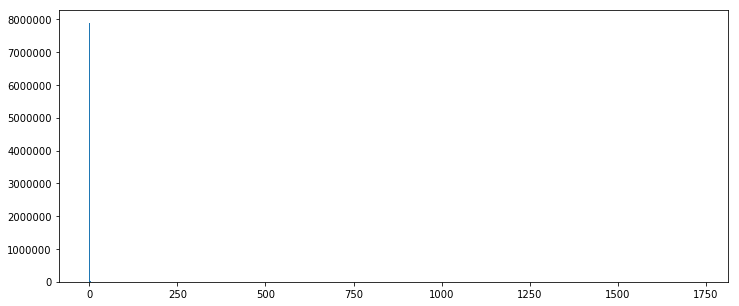

In [87]:
plt.figure(figsize=(12,5)); hh, bb, _ = plt.hist(trainAll.hTime,bins=bbins); plt.show()

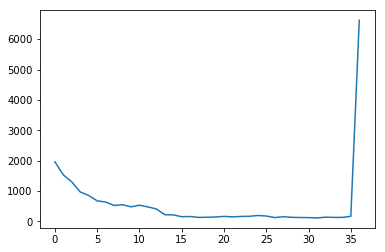

(50, 10596.0, array([  6.41767600e+06,   7.81920000e+04,   1.72610000e+04,
          1.02150000e+04,   7.46600000e+03,   6.46400000e+03,
          6.23000000e+03,   7.07300000e+03,   6.33900000e+03,
          4.01400000e+03,   2.76100000e+03,   2.11200000e+03,
          1.96100000e+03,   1.53100000e+03,   1.30000000e+03,
          9.69000000e+02,   8.53000000e+02,   6.78000000e+02,
          6.38000000e+02,   5.25000000e+02,   5.50000000e+02,
          4.81000000e+02,   5.35000000e+02,   4.78000000e+02,
          4.11000000e+02,   2.22000000e+02,   2.16000000e+02,
          1.55000000e+02,   1.63000000e+02,   1.33000000e+02,
          1.38000000e+02,   1.46000000e+02,   1.66000000e+02,
          1.51000000e+02,   1.64000000e+02,   1.69000000e+02,
          1.96000000e+02,   1.78000000e+02,   1.28000000e+02,
          1.56000000e+02,   1.35000000e+02,   1.30000000e+02,
          1.26000000e+02,   1.16000000e+02,   1.40000000e+02,
          1.33000000e+02,   1.33000000e+02,   1.69000000e

In [96]:
plt.plot(hh[12:]); plt.show()
len(bb), hh[24:].sum(), hh, bb

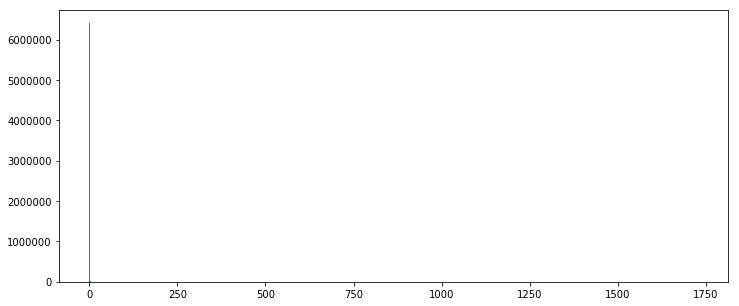

In [95]:
plt.figure(figsize=(12,5)); hh, bb, _ = plt.hist(testAll.hTime,bins=bbins); plt.show()

In [369]:
hTimeMin = 3.0/3600.0
hTimeMax = 48.0

hTimeMin = 10.0/3600.0
hTimeMax = 48.0

OKtrain = ((trainAll.hTime<=hTimeMax) & (trainAll.hTime>hTimeMin))
NOtrain = np.logical_not(OKtrain)
OKtest  = ((testAll.hTime<=hTimeMax) & (testAll.hTime>hTimeMin))
NOtest  = np.logical_not(OKtest)


print('All tracks: \ttrain={}, test={}\nTracks with wrong records:  \ttrain={}, test={}\nTracks with good records:  \ttrain={}, test={}'. \
          format(len(trainAll.TrackNumber.unique()),len(testAll.TrackNumber.unique()), \
                 len(trainAll.TrackNumber[NOtrain].unique()), \
                 len(testAll.TrackNumber[NOtest].unique()), \
                 len(trainAll.TrackNumber[OKtrain].unique()), \
                 len(testAll.TrackNumber[OKtest].unique())))

All tracks: 	train=1209, test=1211
Tracks with wrong records:  	train=1209, test=1211
Tracks with good records:  	train=1209, test=1211


In [157]:
print('train={}, test={}'.format(len(trainAll.TrackNumber[((trainAll.hTime>hTimeMax) | (trainAll.hTime<hTimeMin))]),
                                 len(testAll.TrackNumber[((testAll.hTime>hTimeMax) | (testAll.hTime<hTimeMin))] ) ))

train=938990, test=658466


In [133]:
train[train.hTime> 48.0]

,TrackNumber,Chlorophyll Concentration,Depth,Distance,Eastward Water Velocity,Latitude,Longitude,Northward Water Velocity,Oceanic Depth,SOG,...,Sea Temperature,Speed,Thermocline Depth,Time,Time(seconds),Water Surface Elevation,hTime,oceanic depth,sTime,y
69,100047,0.3114,-4,0.635781,-0.04,41.099857,1.232748,-0.03,NaN,8.9,...,10.6,0.005562,113.6,210835,210835,-0.21,61.726111,-4.0,222214.0,0
93,100047,0.3095,-5,0.905187,-0.21,41.107890,1.238818,-0.10,NaN,0.0,...,10.2,0.004476,123.8,643825,643825,-0.19,109.190278,-5.0,393085.0,0
179,100047,0.3043,-10,3.923416,-0.04,41.078055,1.213548,0.01,NaN,10.6,...,9.9,0.034441,263.1,1420301,1420301,-0.17,61.510556,-10.0,221438.0,0
251,100047,0.3043,-10,2.912001,0.10,41.082810,1.215468,0.04,NaN,10.7,...,9.8,0.025526,323.8,2024705,2024705,-0.21,61.597778,-10.0,221752.0,0
297,100047,0.3092,-5,3.436802,0.05,41.104813,1.239307,0.11,NaN,0.5,...,9.6,0.029979,157.6,2629425,2629425,-0.29,61.900000,-5.0,222840.0,0
359,100047,0.2080,-4,2.703458,-0.06,41.088820,1.221198,0.05,NaN,9.4,...,9.6,0.023528,252.4,3232398,3232398,-0.30,62.043333,-4.0,223356.0,0
418,100047,0.2047,-5,0.207280,-0.12,41.108707,1.240357,0.29,NaN,0.0,...,9.6,0.001338,380.1,3759683,3759683,-0.23,83.626111,-5.0,301054.0,0
453,100047,0.2042,-5,2.327180,-0.12,41.104318,1.241150,0.17,NaN,0.8,...,9.7,0.020191,184.3,4442169,4442169,-0.24,62.235278,-5.0,224047.0,0
473,100047,0.2092,-3,0.086283,0.00,41.083383,1.215767,0.10,NaN,7.3,...,9.9,0.000745,252.4,5046051,5046051,-0.25,62.506389,-3.0,225023.0,0
495,100047,0.1735,-5,3.308095,-0.02,41.105027,1.242002,0.18,NaN,8.4,...,9.8,0.028623,229.6,5651446,5651446,-0.26,62.406389,-5.0,224663.0,0


In [714]:
# Смотрим статистику по судам

True : [569.0, 193.0, 266.0, 53.0, 128.0] 

Train: [572.837, 189.484, 266.883, 49.756, 130.041]
Train: [575.115, 187.272, 265.228, 48.658, 132.727]
Train: [574.706, 185.916, 264.168, 48.01, 136.201]

Test : [584.974, 194.675, 274.295, 33.745, 123.313]
Test : [576.366, 196.283, 274.782, 36.338, 127.231]
Test : [574.318, 201.913, 272.546, 37.461, 124.761]


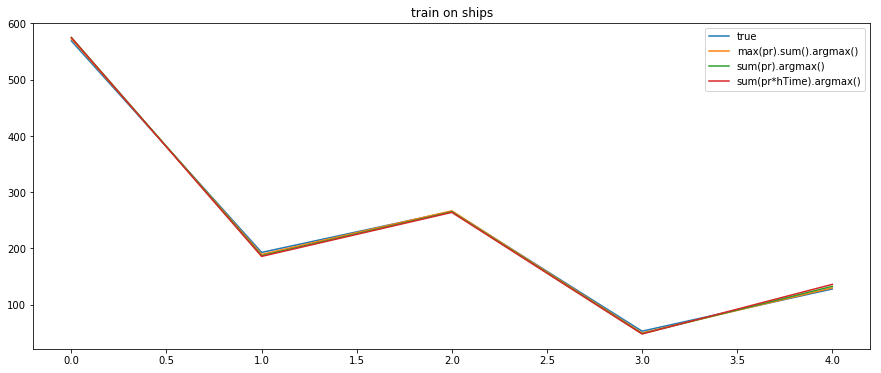

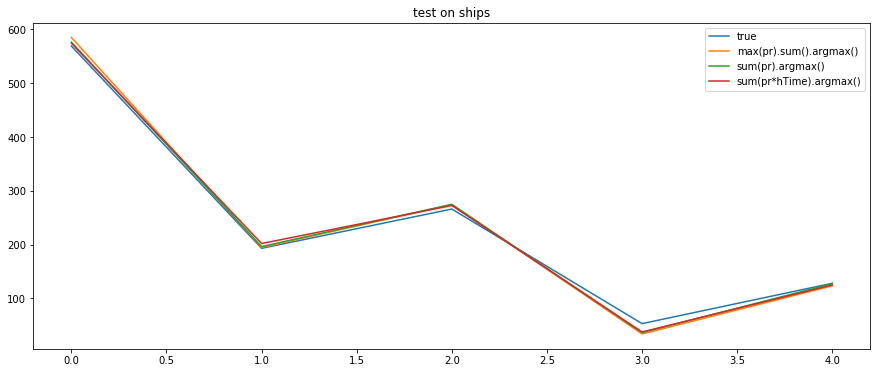

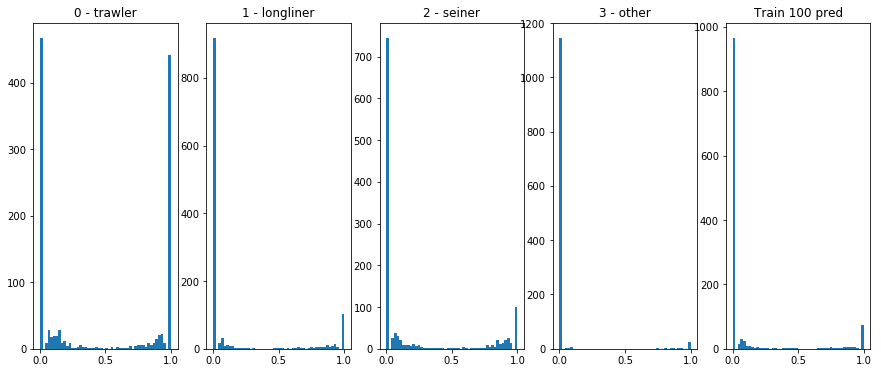

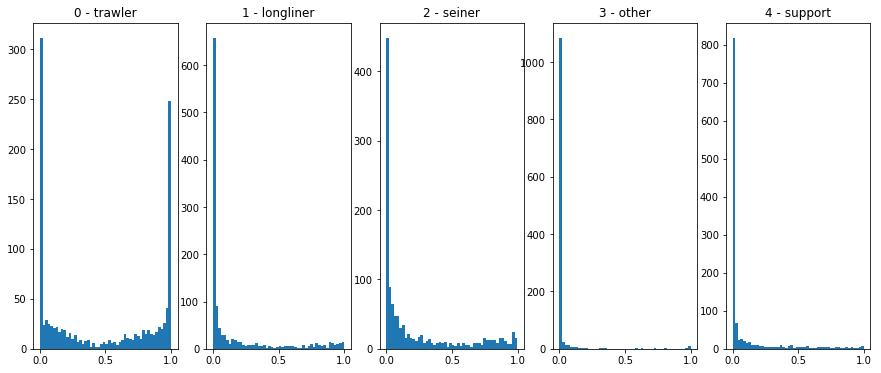

In [813]:
def pr1x5 (df) :
    temp = df.set_index(['TrackNumber','pred_y']).unstack().fillna(0.0)
    temp.columns=[0,1,2,3,4]
    return(temp)
    
train_stat = gg[['TrackNumber','pred_y','true_y']];
##print(gg.head())
#plt.hist()
train_true = train_stat.set_index(['TrackNumber','pred_y']).unstack().fillna(0.0)
train_true.columns=[0,1,2,3,4]

print 'True :', pr1x5(train_stat).sum().tolist(),'\n'

print 'Train:',np.round(pr1x5(tr000).sum(),3).tolist()
print 'Train:',np.round(np.array(pr1x5(tr100).sum(),dtype=np.float),3).tolist()
print 'Train:',np.round(pr1x5(tr110).sum(),3).tolist()
print
print 'Test :',np.round(pr1x5(te000).sum(),3).tolist()
print 'Test :',np.round(np.array(pr1x5(te100).sum(),dtype=np.float),3).tolist()
print 'Test :',np.round(pr1x5(te110).sum(),3).tolist()

plt.figure(figsize=(15,6))
plt.plot(pr1x5(train_stat).sum()); 
plt.plot(pr1x5(tr000).sum()); 
plt.plot(pr1x5(tr100).sum()); 
plt.plot(pr1x5(tr110).sum()); 

plt.legend(['true', 'max(pr).sum().argmax()', 'sum(pr).argmax()', 'sum(pr*hTime).argmax()'])

plt.title('train on ships')
plt.show()

plt.figure(figsize=(15,6))
plt.plot(pr1x5(train_stat).sum()); 
plt.plot(pr1x5(te000).sum()); 
plt.plot(pr1x5(te100).sum()); 
plt.plot(pr1x5(te110).sum()); 

plt.legend(['true', 'max(pr).sum().argmax()', 'sum(pr).argmax()', 'sum(pr*hTime).argmax()'])

plt.title('test on ships')
plt.show()

plt.figure(figsize=(15,6))
temp = pr1x5(tr100)
for ii,nn in enumerate(temp.columns) :
    plt.subplot(1,temp.shape[1],ii+1); plt.hist(temp[nn],bins=50);plt.title(str(nn)+" - "+y_class[ii])
plt.title('Train 100 pred')
plt.show()

plt.figure(figsize=(15,6))
temp = pr1x5(te100)

for ii,nn in enumerate(temp.columns) :
    plt.subplot(1,temp.shape[1],ii+1); plt.hist(temp[nn],bins=50);plt.title(str(nn)+" - "+y_class[ii])
plt.show()

plt.close()
#g0pred.head()

In [1009]:
# Построение массива с данными по списку файлов

def buildX (file_list, nFiles=-1, maxSpeed=35.0, maxSOG=35.0, rWindow=5, hTimeMin=False, hTimeMax=False, fillOK=False) :
    
    
    for ii,ffile in enumerate(file_list) :
        if ii==nFiles : break
        xx = pd.read_csv(os.path.join('../Data/VesselTracks',str(ffile)+'.csv'))
        
        ##print(ii,ffile)
        
        # Small corrections: (latitude&longitude), timing
        
        xx = xx[(xx.Latitude >=-90.0)  & (xx.Latitude <= 90.0)];
        xx = xx[(xx.Longitude>=-180.0) & (xx.Longitude<=180.0)];
        
        xx['Time']  = xx[[1]]
        xx['sTime'] = np.abs(xx.Time.diff(-1)).fillna(0.0)
        xx['hTime'] = xx.sTime/3600.0
        
        if hTimeMin : 
            xx          = xx[xx.hTime>=hTimeMin]
            xx['sTime'] = np.abs(xx.Time.diff(-1)).fillna(0.0)
            xx['hTime'] = xx.sTime/3600.0
            
        havLa       = (0.5*(1.0-np.cos(-xx.Latitude.diff(-1)/180.0*math.pi))).fillna(0.0)
        lLongitude  = xx.Longitude+360.0
        havLo       = (0.5*(1.0-np.cos(-lLongitude.diff(-1)/180.0*math.pi))).fillna(0.0)

        cosLa       = (np.cos(xx.Latitude/180.0*math.pi)).fillna(0.0)

        hav         = (havLa+cosLa*cosLa.shift(-1)*havLo).fillna(0.0)
        dist = (2*6371.0*np.arcsin(np.sqrt(hav))).fillna(0.0)

        xx['Distance'] = dist
        xx['Speed']    = np.round((dist/1.852/xx.hTime).fillna(0.0),2)
        xx.loc[xx.Speed>maxSpeed,'Speed'] = maxSpeed
        
        if hTimeMax : 
            xx.sTime[xx.hTime<=hTimeMax] = 0.0
            xx.hTime[xx.hTime<=hTimeMax] = 0.0
        
        # rolling Speed
        rSOG      = xx.SOG.rolling(window=rWindow, min_periods=1).mean()
        rSOGmd    = xx.SOG.rolling(window=rWindow, min_periods=1).median()
        rSpeed    = xx.Speed.rolling(window=rWindow, min_periods=1).mean()
        rDistance = xx.Distance.rolling(window=rWindow, min_periods=1).mean()
        rTime     = xx.hTime.rolling(window=rWindow, min_periods=1).mean()
        rDTSpeed = (rDistance/rTime/1.852).fillna(0.0)
        
        xx['rSpeed'] = np.round(np.clip(rSpeed,0.0,maxSpeed),2)
        xx['rSOG']   = np.round(np.clip(rSOG,0.0,maxSpeed),2)
        xx['rSOGmd'] = np.round(np.clip(rSOGmd,0.0,maxSpeed),2)
        xx['rDTSpeed'] = np.round(np.clip(rDTSpeed,0.0,maxSpeed),2)
        
        xx.loc[xx.SOG>maxSOG,'SOG'] = xx.loc[xx.SOG>maxSOG,'rSOG']
        xx.loc[xx.SOG<0.0,'SOG']    = xx.loc[xx.SOG<0.0,'rSOG']

        if fillOK : xx = xx.fillna(fillOK)

        if (ii==0) : resAll = xx.copy()
        else       : resAll = resAll.append(xx.copy())

    ##print(trainAll.shape)
    return (resAll)

def buildY (file_list, y_classes) :
    
    trainIndex=file_list.copy()
    trainIndex['y'] = np.array(map(y_classes.index,trainIndex.typing.tolist()))
    return(trainIndex)

In [1389]:
def plot_trass_fl (df) :
    plt.plot(df['Longitude'].values.tolist(),df['Latitude'].values.tolist());
    plt.show();
def plot_trass_sp (df) :
    axx = df['hTime'].cumsum().values.tolist()
    plt.scatter(axx,df['SOG']);    legenda  = ['SOG']
    plt.scatter(axx,df['rSOG']);   legenda += ['rSOG']
    plt.scatter(axx,df['rSOGmd']); legenda += ['rSOGmd']
    #plt.scatter(axx,df['rSpeed']); legenda += ['rSpeed']
    #plt.plot(df['rDTSpeed']); legenda += ['rDTSpeed']
    #plt.plot(df['Speed']); legenda += ['Speed']
    plt.legend(legenda)
    plt.show();

def plot_dist (df) :
    plt.plot(df['Distance'].cumsum());    legenda  = ['Distance']
    plt.legend(legenda)
    plt.show();
    
def plot_hours (df) :
    plt.plot(df['hTime'].cumsum());    legenda  = ['hTime']
    plt.legend(legenda)
    plt.show();
                
def plot_dh (df) :
    plt.plot(df['hTime'].cumsum().values.tolist(),df['Distance'].cumsum().values.tolist());
    plt.show();
    
def plot_yh (df, pry) :
    ##print(pry)
    pryr = pd.Series(np.array(np.round(pry[:,0],0),dtype=np.int32)).rolling(window=9, min_periods=1,center=True).median()
    print(pryr.unique())
    
    pryr = np.round(pryr,0)
    
    print('res:',[(xx,yy.count()) for xx,yy in pd.Series(pry[:,0]).groupby(pry[:,0])])
    print('rol:',[(xx,yy.count()) for xx,yy in pryr.groupby(pryr)])
    ##print(pryr.head())
    
    plt.plot(df['hTime'].cumsum().values.tolist(),pry);
    plt.plot(df['hTime'].cumsum().values.tolist(),pryr);
    
    plt.show();


In [1390]:
print trainIndex.y.groupby(trainIndex.y).count()
[(xx,yy.count()) for xx,yy in trainIndex.y.groupby(trainIndex.y)]

y
0    569
1    193
2    266
3     53
4    128
Name: y, dtype: int64


[(0, 569), (1, 193), (2, 266), (3, 53), (4, 128)]

In [1391]:
def plotting (inns, trackIndex, trainAll, pred_y) :
    
    for inn in inns.values.tolist() :

        nn   = trainIndex.loc[trainIndex.trackfile==inn,'typing'].values
        temp = trainAll.loc[trainAll.TrackNumber==inn]

        print('*'*90)
        print(str(inn)+' - '+nn, '-'*40)
        print('Distance: {} hTime: {} Distance(max)={} Points={}'.format(temp['Distance'].sum(),temp['hTime'].sum(),temp['Distance'].max(),len(temp)))
        print('SOG: \tmean={} median={} minmax = {}-{}'.format(temp['SOG'].mean(),temp['SOG'].median(),temp['SOG'].min(),temp['SOG'].max()))
        print('rSOG: \tmean={} median={} minmax = {}-{}'.format(temp['rSOG'].mean(),temp['rSOG'].median(),temp['rSOG'].min(),temp['rSOG'].max()))
        print('Speed: \tmean={} median={} minmax = {}-{}'.format(temp['Speed'].mean(),temp['Speed'].median(),temp['Speed'].min(),temp['Speed'].max()))
        print('rSp: \tmean={} median={} minmax = {}-{}'.format(temp['rSpeed'].mean(),temp['rSpeed'].median(),temp['rSpeed'].min(),temp['rSpeed'].max()))
        
        if 1 :
            temp1  = pred_y[trainAll.TrackNumber==inn]
            temp2  = np.reshape(temp1.argmax(axis=1),(temp1.shape[0],1));
            plt.figure(figsize=(15,3)); plt.title(str(inn)+' - '+nn+' predictions'); plot_yh(temp,temp2)

        plt.figure(figsize=(15,5)); plt.title(str(inn)+' - '+nn+' Speeds'); plot_trass_sp(temp)

        plt.figure(figsize=(15,3)); plt.title(str(inn)+' - '+nn+' Distance-Time'); plot_dh(temp)
        
        plt.figure(figsize=(15,3)); plt.title(str(inn)+' - '+nn); plot_trass_fl(temp)


        #plt.figure(figsize=(15,5)); plt.title(str(inn)+' - '+nn); plot_dist(temp)
        #plt.figure(figsize=(15,5)); plt.title(str(inn)+' - '+nn); plot_hours(temp)

In [1392]:
#trainAll_ = buildX(train_list['trackfile'].values.tolist(), nFiles=101, hTimeMin=5.0/3600, rWindow=5);

   trackfile     typing  y
0     100047    trawler  0
1     100070  longliner  1
2     100080     seiner  2
3     100093      other  3
4     100144    trawler  0
(7, [104192, 105633, 110845, 112232, 115701, 126567, 126867])
******************************************************************************************
(array(['104192 - support'], dtype=object), '----------------------------------------')
Distance: 508.118603329 hTime: 59.0105555556 Distance(max)=7.42770646845 Points=372
SOG: 	mean=5.7438172043 median=7.7 minmax = 0.0-10.6
rSOG: 	mean=5.7438172043 median=7.66 minmax = 0.0-10.02
Speed: 	mean=5.61889784946 median=7.635 minmax = 0.0-35.0
rSp: 	mean=5.61900537634 median=7.32 minmax = 0.0-13.34
[ 4.  3.  2.  0.  1.]
('res:', [(0, 70), (1, 48), (2, 58), (4, 196)])
('rol:', [(0.0, 72), (1.0, 54), (2.0, 67), (3.0, 1), (4.0, 178)])


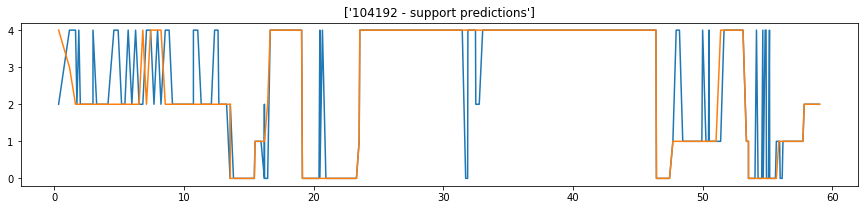

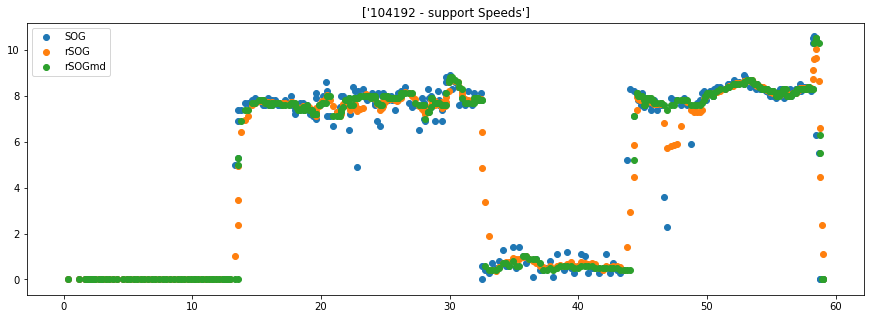

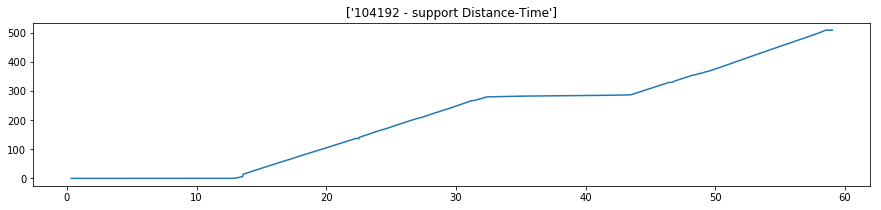

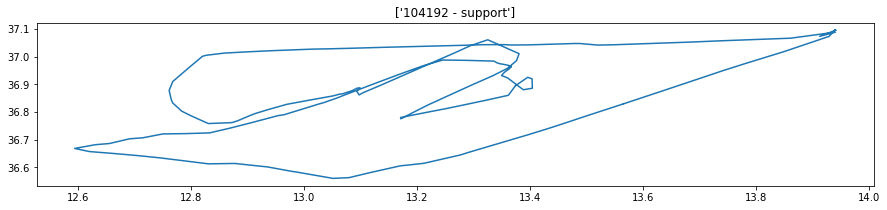

******************************************************************************************
(array(['105633 - support'], dtype=object), '----------------------------------------')
Distance: 57057.8019634 hTime: 2207.28277778 Distance(max)=6412.80489882 Points=6587
SOG: 	mean=9.48749051161 median=12.5 minmax = 0.0-16.6
rSOG: 	mean=9.49080613329 median=12.36 minmax = 0.0-16.54
Speed: 	mean=9.38523758919 median=12.26 minmax = 0.0-35.0
rSp: 	mean=9.38898436314 median=12.04 minmax = 0.0-17.61
[ 4.  2.  1.]
('res:', [(1, 18), (2, 1880), (4, 4689)])
('rol:', [(1.0, 6), (2.0, 1834), (4.0, 4747)])


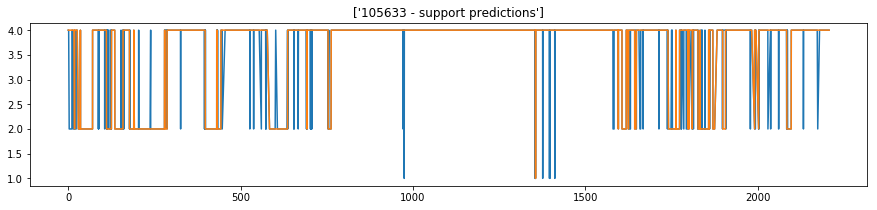

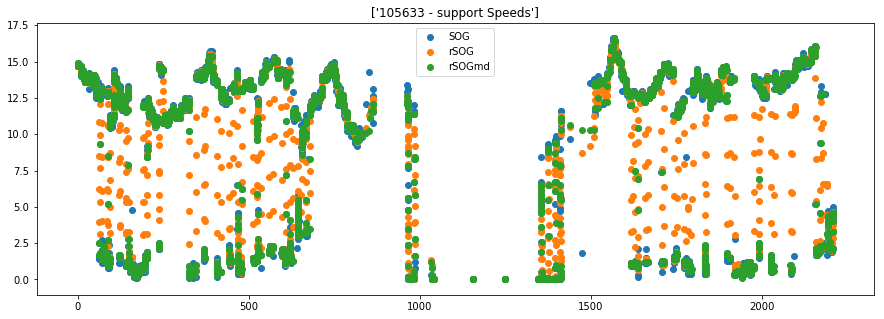

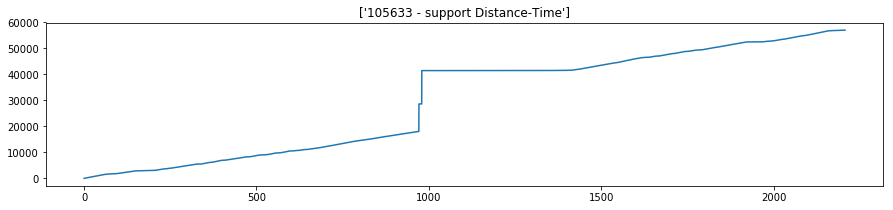

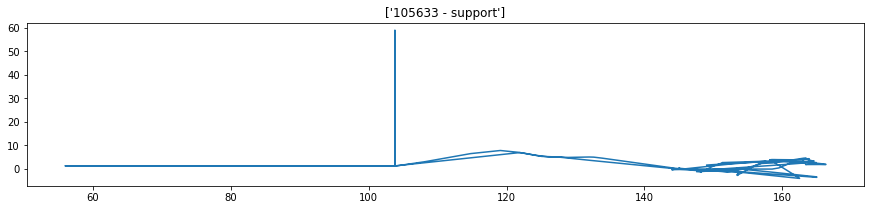

******************************************************************************************
(array(['110845 - support'], dtype=object), '----------------------------------------')
Distance: 35676.7260057 hTime: 2188.53194444 Distance(max)=7579.18339849 Points=2881
SOG: 	mean=4.1335300243 median=0.7 minmax = 0.0-13.3
rSOG: 	mean=4.1378167303 median=3.02 minmax = 0.0-12.6
Speed: 	mean=3.70328705311 median=0.4 minmax = 0.0-35.0
rSp: 	mean=3.70665046859 median=1.95 minmax = 0.0-21.12
[ 1.  2.  4.  0.  3.]
('res:', [(0, 13), (1, 556), (2, 650), (4, 1662)])
('rol:', [(0.0, 8), (1.0, 464), (2.0, 723), (3.0, 2), (4.0, 1684)])


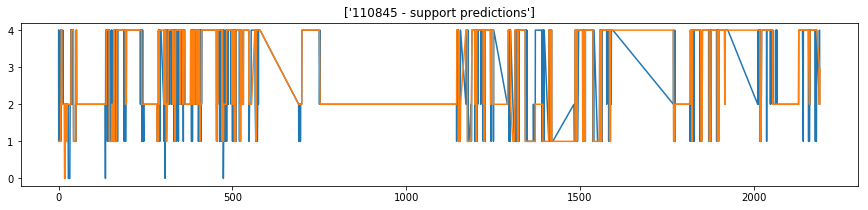

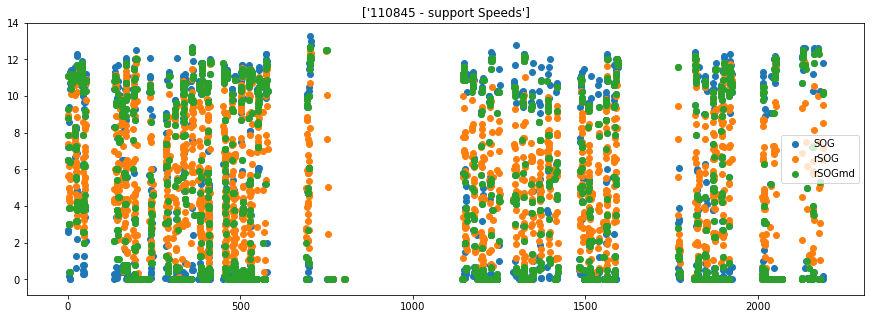

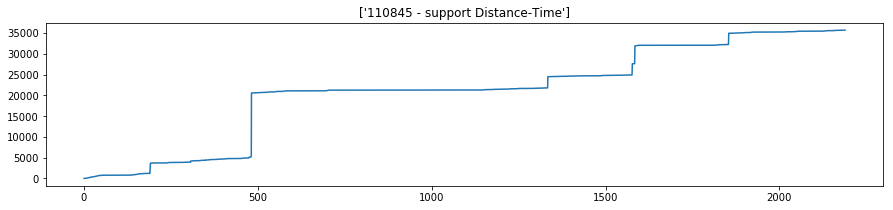

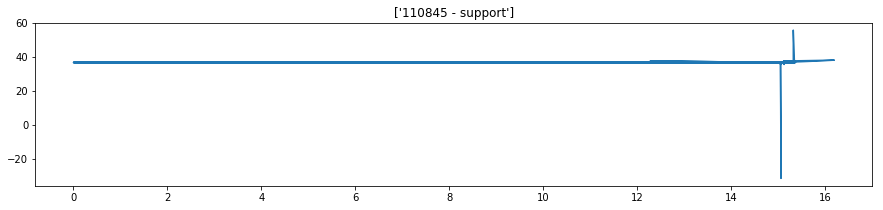

******************************************************************************************
(array(['112232 - support'], dtype=object), '----------------------------------------')
Distance: 9331.48783075 hTime: 2191.69111111 Distance(max)=196.399166411 Points=4364
SOG: 	mean=7.13295142071 median=11.1 minmax = 0.0-16.4
rSOG: 	mean=7.13297891842 median=10.82 minmax = 0.0-16.24
Speed: 	mean=6.96459670027 median=10.35 minmax = 0.0-32.98
rSp: 	mean=6.96460586618 median=10.16 minmax = 0.0-17.16
[ 4.  2.]
('res:', [(2, 976), (4, 3388)])
('rol:', [(2.0, 908), (4.0, 3456)])


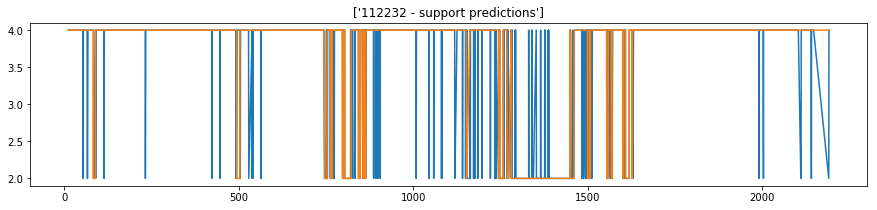

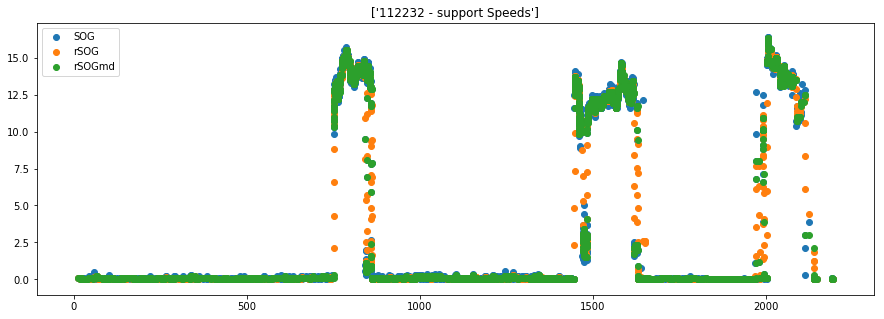

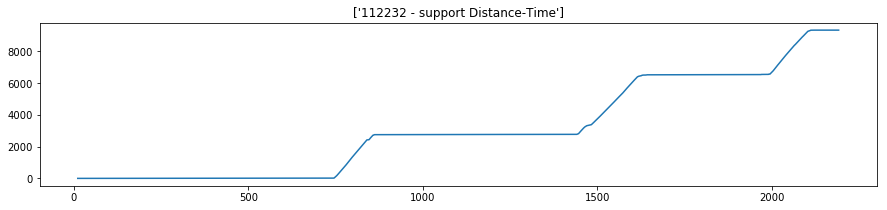

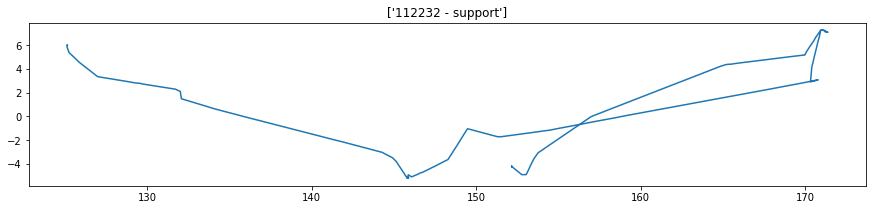

******************************************************************************************
(array(['115701 - support'], dtype=object), '----------------------------------------')
Distance: 2724.94567258 hTime: 1550.91861111 Distance(max)=675.727198117 Points=1759
SOG: 	mean=1.14525298465 median=0.0 minmax = 0.0-11.1
rSOG: 	mean=1.14962478681 median=0.0 minmax = 0.0-9.32
Speed: 	mean=1.14469584991 median=0.02 minmax = 0.0-11.26
rSp: 	mean=1.14924957362 median=0.02 minmax = 0.0-9.57
[ 4.  2.  1.]
('res:', [(1, 35), (2, 348), (4, 1376)])
('rol:', [(1.0, 29), (2.0, 348), (4.0, 1382)])


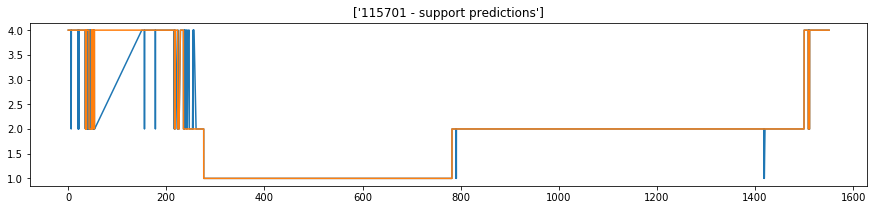

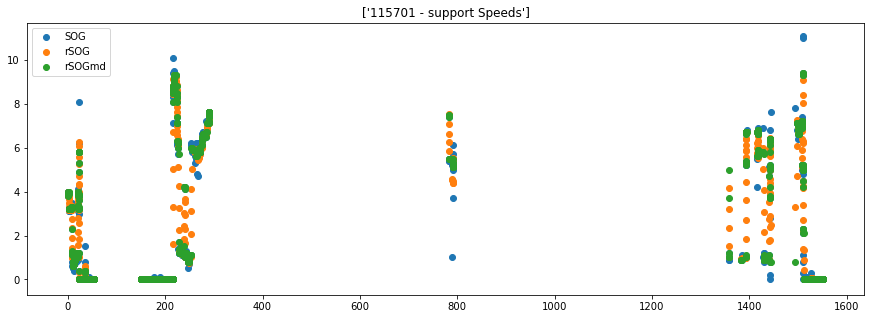

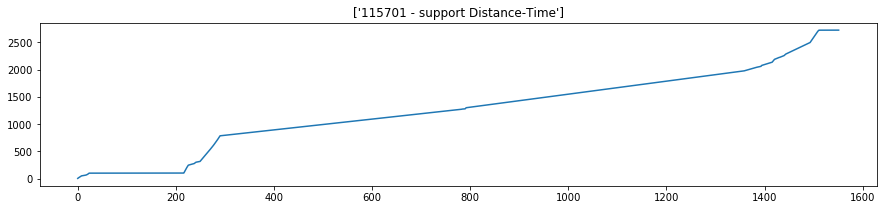

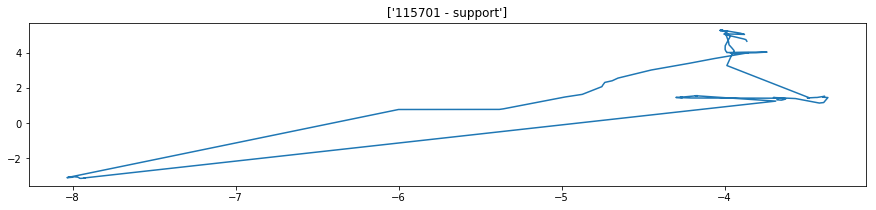

******************************************************************************************
(array(['126567 - support'], dtype=object), '----------------------------------------')
Distance: 662.061479605 hTime: 2018.97388889 Distance(max)=12.8619688838 Points=447
SOG: 	mean=1.29284116331 median=0.0 minmax = 0.0-7.4
rSOG: 	mean=1.31982102908 median=0.08 minmax = 0.0-6.6
Speed: 	mean=0.843288590604 median=0.0 minmax = 0.0-7.33
rSp: 	mean=0.843243847875 median=0.16 minmax = 0.0-5.24
[ 4.  3.  2.]
('res:', [(2, 240), (3, 1), (4, 206)])
('rol:', [(2.0, 263), (3.0, 1), (4.0, 183)])


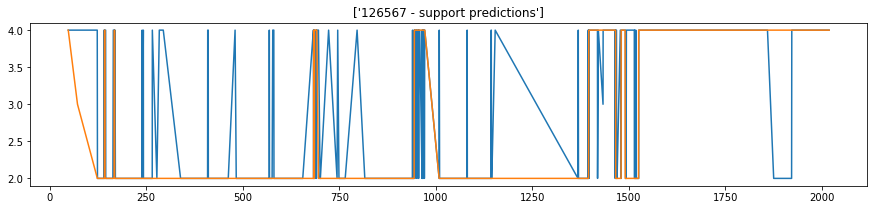

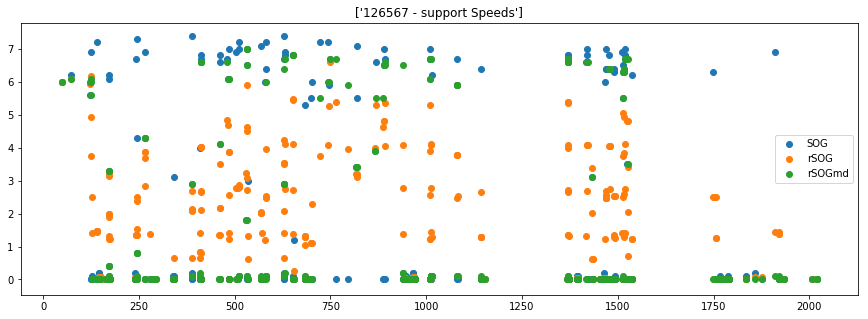

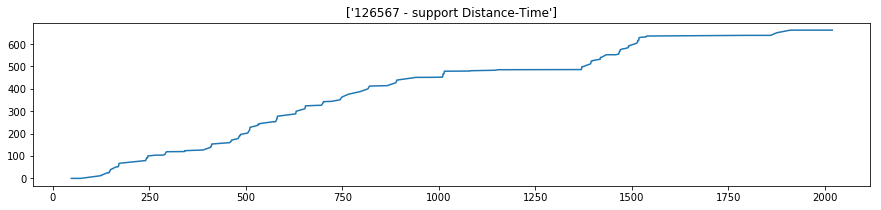

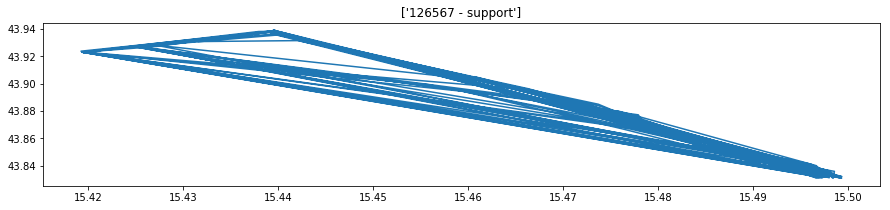

******************************************************************************************
(array(['126867 - support'], dtype=object), '----------------------------------------')
Distance: 61554.1745056 hTime: 2205.90444444 Distance(max)=13750.2697435 Points=6349
SOG: 	mean=8.5406678217 median=10.2 minmax = 0.0-13.3
rSOG: 	mean=8.54365411876 median=10.06 minmax = 0.06-13.22
Speed: 	mean=8.29043156403 median=10.03 minmax = 0.0-35.0
rSp: 	mean=8.29319420381 median=9.74 minmax = 0.0-21.55
[ 4.  2.  1.]
('res:', [(0, 1), (1, 16), (2, 1428), (4, 4904)])
('rol:', [(1.0, 7), (2.0, 1387), (4.0, 4955)])


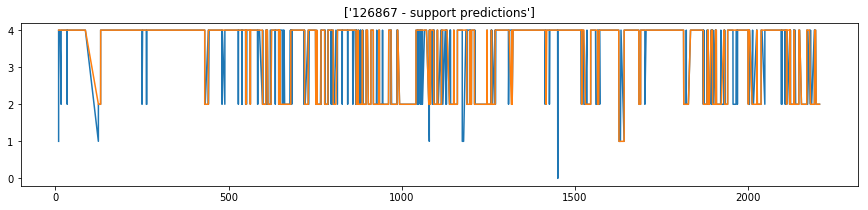

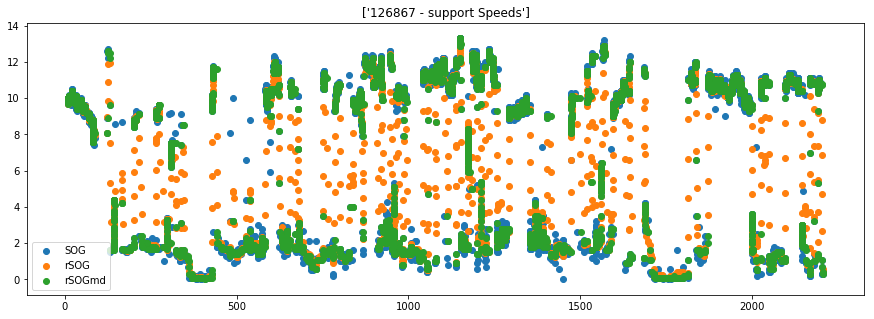

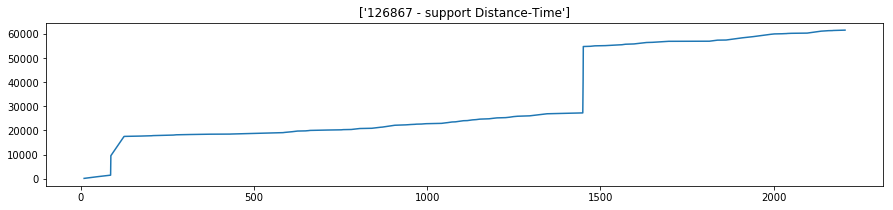

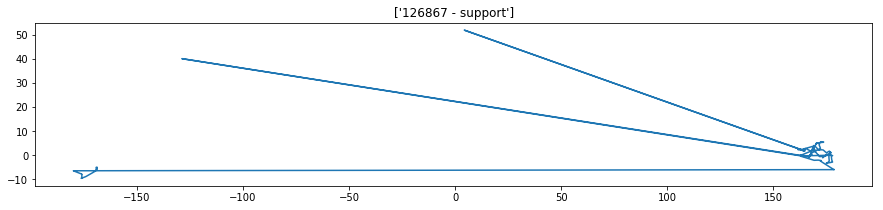

In [1394]:
##trainAll.TrackNumber.head()
print(trainIndex.head())

y   = 4
ypr = 0.7

yy_pred0 = pd.DataFrame(pred_y).groupby(trainAll.TrackNumber).sum(); ##print(yy_pred0.head())
yy_pred1 = yy_pred0.sum(axis=1); #print(yy_pred1.head())
yy_pred0_columns = yy_pred0.columns
for ii in yy_pred0_columns :
    yy_pred0[ii] /= yy_pred1
yy_pred0['yy'] = 0.0
yy_pred0['y']  = trainIndex.set_index('trackfile').y
for ii in yy_pred0_columns :
    yy_pred0.loc[yy_pred0.y==ii,'yy'] = yy_pred0.loc[yy_pred0.y==ii,ii]
yy_pred0 = yy_pred0.reset_index()
##print(yy_pred0.head())
inns = yy_pred0[(yy_pred0.y==y) & (yy_pred0.yy<=ypr)].TrackNumber
print(len(inns),inns.head(20).values.tolist())


plotting(inns[:10],trainIndex,trainAll,pred_y)

In [960]:
8000.0/(14*1.852)/24.0

12.856114367993419

In [999]:
2*math.pi*6371

40030.173592041145

In [1144]:
##nn   = trainIndex.loc[trainIndex.trackfile==inn,'typing'].values
temp0  = trainAll.loc[trainAll.TrackNumber==100854]
temp1  = pred_y[trainAll.TrackNumber==100854]
temp2  = np.reshape(temp1.argmax(axis=1),(temp1.shape[0],1)); print(temp2.shape)
print(temp1.shape,temp.shape)
temp   = np.hstack([temp1,temp2,temp0.values])
temp10 = pd.DataFrame(temp,columns=range(temp1.shape[1])+['y']+temp0.columns.tolist())
temp10.tail()



(412, 1)
((412, 5), (412, 29))


,0,1,2,3,4,y,Chlorophyll Concentration,Distance,Eastward Water Velocity,Latitude,...,Time(seconds),TrackNumber,Water Surface Elevation,hTime,oceanic depth,rDTSpeed,rSOG,rSOGmd,rSpeed,sTime
407,0.438752,0.548424,0.012572,0.000194,0.000057,1.0,0.6317,56.999759,0.10,52.101043,...,6709266.0,100854.0,-1.50,3.542500,-28.0,8.44,8.68,8.7,7.93,12753.0
408,0.147233,0.849245,0.003224,0.000281,0.000017,1.0,0.7536,10.532117,-0.02,52.137578,...,6722019.0,100854.0,-1.47,0.694722,-90.0,8.39,8.54,8.7,7.77,2501.0
409,0.342819,0.644803,0.012149,0.000211,0.000018,1.0,0.8754,38.069526,0.01,52.149630,...,6724520.0,100854.0,-1.46,2.617222,-125.0,8.21,8.42,8.4,7.58,9422.0
410,0.764154,0.219753,0.015817,0.000241,0.000036,0.0,0.8874,47.087229,0.12,52.199865,...,6733942.0,100854.0,-1.41,3.277222,-208.0,8.05,8.22,8.3,7.46,11798.0
411,0.356260,0.637619,0.005954,0.000062,0.000105,1.0,0.3741,0.000000,0.08,52.266240,...,6745740.0,100854.0,-1.41,0.000000,-151.0,8.14,7.96,7.9,6.50,0.0
